In [1]:
# --- Importing Libraries -------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import winsound
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LogisticRegression as LRC
from sklearn.svm import SVC, LinearSVC
from IPython.display import SVG
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import BaggingClassifier as BAG
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from mlxtend.classifier import EnsembleVoteClassifier as EVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import combinations
from skopt import BayesSearchCV as BSCV
from skopt.space import Real, Categorical, Integer

# --- Matplotlib Settings -------------------------------------------------------
matplotlib.rc('figure', facecolor='k')
style.use('dark_background')

# --- Pandas Display Settings ---------------------------------------------------
pd.options.display.width = 113
pd.options.display.max_columns = 100
pd.options.display.colheader_justify='right'

# --- Importing CVSs ------------------------------------------------------------
raw = pd.read_csv('german_data.csv') # categoricals are phrases or words
doc = pd.read_csv('german_data_original.csv')# ordinals are alphanumeric codes
don = pd.read_csv('german_data_original_numeric.csv')# ordinals are numeric ranks

# Calculates probabilities using Bayes Theorem
def CALCULATE_POSTERIOR_PROB(data, feature, sort='lk_GC', ascending=False):
    """
    Analyzes each category of each categorical feature using Bayes Theorem
    """
    # n_C is number of instances of this category 
    counts = data[feature].value_counts()
    bins = data[feature].unique().tolist()
    table = []
    
    for n, category in enumerate(bins):
        
        filtered_data = data[data[feature]==category].loc[:,'default']
        
        # Number of instances of the category
        nC = counts[bins[n]]
        
        # Prior: Probability of being in this category
        pC = float(nC) / 1000
        
        # Within this category, how many defaulted (B for Bad) and how many did not (G for Good)
        nBC = len(filtered_data[filtered_data==1])
        nGC = len(filtered_data) - nBC
        
        # Likelihoods for this category
        pBC = nBC / float(nC) # P(B|C)
        pGC = nGC / float(nC) # P(G|C)
        
        # Posteriors for this category
        pCB = ( pBC * pC ) / 0.3
        pCG = ( pGC * pC ) / 0.7
        
        # Entropy
        hC = pC * np.log2(1 / pC)
        
        # Joint Entropy
        hCB = (nBC * 0.001) * np.log2(1 / (nBC * 0.001))
        hCG = (nGC * 0.001) * np.log2(1 / (nGC * 0.001))
        
        # Mutual Information
        iCB = (nBC * 0.001) * np.log2((nBC * 0.001) / (pC * 0.3))
        iCG = (nGC * 0.001) * np.log2((nGC * 0.001) / (pC * 0.7))
        
        pC, pCB, pCG, pBC, pGC = pC*100, pCB*100, pCG*100, pBC*100, pGC*100
        table.append([ feature, category, pCG-pCB, pC,
                      nBC, nGC, pCB, pCG, pBC, round(pGC, 2),
                      hC, hCB, hCG, iCB, iCG])
        
    table = pd.DataFrame(data=table,columns=['Feature', 'Category', 'Ratio', 'P(C)',
                                             'Bad', 'Good', 'P(C|B)', 'P(C|G)', 'lk_BC', 'lk_GC',
                                             'H(C)', 'H(C,B)', 'H(C,G)', 'I(C,B)', 'I(C,G)'])
    table = table.sort_values(by=sort, axis=0, ascending=ascending)
    return table

## 1. Feature Engineering: Creating New Numerical Features
---
- Minimum Salary Requirement:
    - $ MSR = Amount \times \Big( 1 + \frac{Rate}{100} \Big) \times Time $
- Total Profit: 
    - $ TPR = Amount \times \Big( \frac{Rate}{100} \Big) \times Time $
- Interaction 1: 
    - $ IN1 = Amount \times \Big( \frac{Rate}{100} \Big) $

In [2]:
# --- Creating the new features -------------------------------------------------
# MSR (Minimum Salary Requirement) units in thousands
MSR = raw['amount']*(1+(0.01*raw['inst_rate']))*raw['loan_time']*0.001
MSR.name = 'MSR'

# TPR (Total Profit)
TPR = raw['amount']*0.01*raw['inst_rate']*raw['loan_time']
TPR.name = 'TPR'

# IN1 (Interaction 1)
IN1 = raw['amount']*0.01*raw['inst_rate']
IN1.name = 'IN1'

# Displaying statistical summary
pd.options.display.float_format = '{:8.2f}'.format
print pd.concat([MSR, TPR, IN1], axis=1).describe().T

       count     mean      std      min      25%      50%      75%      max
MSR  1000.00    92.10   131.56     1.53    18.15    41.03   101.63   957.96
TPR  1000.00  2469.32  3623.67    24.04   465.69  1117.80  2824.59 33664.80
IN1  1000.00    88.70    79.48     5.00    38.64    62.28   109.75   572.72


## 2. Creating dataset, training set and hold-out set
---

In [3]:
# --- Attaching New Numerical Features and Installment Rate ---------------------
'''
[NOTE]
Installment Rate (INR) is there in the repository that this dataset was obtained 
from (raw) but that same repository has 2 other formats of the same dataset, one 
having categorical/ordinals (doc dataset) in alphanumeric format (i.e. no implied 
rankings) and the other having numerical rankings for the ordinal features (don
dataset). The numerical dataset was deemed most useful to use however it has INR 
missing (along with a few more changes)

Also... columns names have been altered after they had been downloaded from the
online public repository
'''
# Indentifying column names to use for new dataset
# Numerical features
nume = ['DUR', 'AMT', 'INR', 'RES', 'AGE', 'CRD', 'PPL'] # taken from doc dataset
# Ordinal features (encoded as rankings)
ordi = ['CHK', 'HIS', 'SAV', 'EXP', 'SEX', 'PPT', 'OIP'] # taken from don dataset
# Binary features
bina = ['TEL', 'FRN', 'car_new', 'car_used', 'deb_none', # taken from don dataset
        'deb_coap', 'rents', 'owns', 'unemp', 'unskilled', 'skilled']

# Appending features and creating new dataset
df = pd.concat([doc[nume], MSR, TPR, IN1, don[ordi], don[bina]], axis=1)
feature_names = df.columns.tolist()

# Editting Class Labels: 0 is Bad and 1 is Good
y = [1 if label == 1 else 0 for label in don['default'].values]
print '>>> Number of Good (1) in y:', sum(y)
print '>>> Number of Bad (0) in y: ', 1000-sum(y)

# Creating Training and Hold-Out Set
X_train, X_test, y_train, y_test = train_test_split(df.values, y, 
                                                    random_state = 2018)

# Printing summaries about the training and hold-out sets
print '\n>>> Train size:', len(y_train)
print '>>> Test size: ', len(y_test)
print '\n>>> -ve class in train: {} ({}%)'.format(y_train.count(0),
                                              y_train.count(0)*100/len(y_train))
print '>>> -ve class in test:  {}  ({}%)\n'.format(y_test.count(0),
                                             y_test.count(0)*100/len(y_test))
print '>>> First 6 records of the new dataset'
pd.options.display.float_format = '{:8.6g}'.format
print df.head(6).T
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

>>> Number of Good (1) in y: 700
>>> Number of Bad (0) in y:  300

>>> Train size: 750
>>> Test size:  250

>>> -ve class in train: 218 (29%)
>>> -ve class in test:  82  (32%)

>>> First 6 records of the new dataset
                 0        1        2        3        4        5
DUR              6       48       12       42       24       36
AMT           1169     5951     2096     7882     4870     9055
INR              4        2        2        2        3        2
RES              4        2        3        4        4        4
AGE             67       22       49       45       53       35
CRD              2        1        1        1        2        1
PPL              1        1        2        2        2        2
MSR        7.29456  291.361   25.655  337.665  120.386    332.5
TPR         280.56  5712.96   503.04  6620.88   3506.4   6519.6
IN1          46.76   119.02    41.92   157.64    146.1    181.1
CHK              1        2        4        1        1        4
HIS             

## 3. Recursive Feature Elimination (Attempt)
---
Investigating the effect of reducing features on accruacy and cost with a Random Forest Classifier. The classifier is first tuned with Bayesian Search, convergence results are then plotted and then the actual RFC is conducted.

In [4]:
# --- Defining Custom Cost Function ---------------------------------------------******************************
def custom_cost_function(y_true, y_pred):
    '''
    [Description]
    -----------------------------------------------------------------------------
    As per requirements of the dataset documentation, the model should penalise
    false positives (incorrectly identified credible cases) as five times worse
    than false negatives. This function calculates this custom cost function for
    implementation with the sklearn metrics package. Cost function value is
    negated as per conventions of the metrics package.
    '''
    
    score = 0
    for i, pred in enumerate(y_pred):
        
        # False Negative
        if pred == 0 and y_true[i] == 1:
            score = score - 1
        
        # False Positive
        elif pred == 1 and y_true[i] == 0:
            score = score - 5
    
    return score

# --- Modes ---------------------------------------------------------------------
cost_function = metrics.make_scorer(custom_cost_function)
mode = 'score_by_custom_cost_function'; scoring = cost_function
#mode = 'score_by_roc_auc'; scoring = 'roc_auc'

# --- Declaring Hyperparameters for the Random Forest Classifier ----------------
params = {'n_estimators': Integer(1, 100),
          'criterion': Categorical(['gini','entropy']),
          'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
          'max_depth': Integer(1, 10),
          'bootstrap': Categorical([True, False]),
          'random_state': Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

# --- Bayesian Search with embedded k-fold cross-validation ---------------------
folds = 3
iterations = 20
DT_rfc = RFC(class_weight='balanced', n_jobs=-1) # Random Forest Classifier
hps = BSCV(DT_rfc, params, cv=folds, n_iter=iterations, scoring=scoring, 
           iid=True, return_train_score=False, random_state=2018)
hps.fit(X_train, y_train)
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

# --- Formating and Displaying Hyperparamter Search Results ---------------------
res = pd.DataFrame(hps.cv_results_)
a = res[['mean_test_score', 'std_test_score']]
res.drop(['mean_test_score', 'std_test_score', 'params', 'mean_fit_time', 
          'mean_score_time', 'std_fit_time', 'std_score_time', 
          'rank_test_score'], axis=1, inplace=True)
if mode == 'score_by_custom_cost_function':
    total_loss = res.loc[:, 'split0_test_score']
    for i in range(1, folds):
        total_loss = total_loss + res.loc[:, 'split{}_test_score'.format(i)]
    total_loss.name = 'total_loss'
    res = pd.concat([total_loss, a, res], axis=1)
    res.sort_values(by=['total_loss'], inplace=True, ascending=False)
else:
    res = pd.concat([a, res], axis=1)
    res.sort_values(by=['mean_test_score'], inplace=True, ascending=False)
pd.options.display.float_format = '{:.4g}'.format
print '>>> Bayesian Hyperparameter Search top 5 results:'
print res.head(5).T

# --- Feature Importance Results ------------------------------------------------
print '\n>>> Feature importances of best found classifier:'
feature_importances = pd.DataFrame(data=hps.best_estimator_.feature_importances_,
                                   index=feature_names, columns=['impt'])
pd.options.display.float_format = '{:.2g}'.format
print '\n', feature_importances.T

# --- Hold-Out Set Performance --------------------------------------------------
y_pred = hps.best_estimator_.predict(X_test)
pd.options.display.float_format = '{:.4g}'.format
print '\n>>> Hold-Out Set Performance:' 
print pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                   columns = ['Pred Bad', 'Pred Good'],
                   index = ['Actual Bad', 'Actual Good'])
print '\nHold-Out Set Loss:', custom_cost_function(y_test, y_pred)
print 'Hold-Out Set Accuracy:', metrics.accuracy_score(y_test, y_pred)

C:\Users\Armin\Anaconda2\lib\site-packages\skopt\optimizer\optimizer.py:369: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


>>> Bayesian Hyperparameter Search top 5 results:
                                     19       12       13       17       2 
total_loss                         -461     -461     -473     -475     -476
mean_test_score                  -153.7   -153.7   -157.7   -158.4   -158.7
std_test_score                    18.56    18.56    15.19    16.37    21.77
param_bootstrap                   False    False    False     True     True
param_criterion                 entropy  entropy  entropy  entropy  entropy
param_max_depth                       5        5        4        5        3
param_min_weight_fraction_leaf     0.03     0.03     0.03     0.01     0.01
param_n_estimators                   69       69       69       28       33
param_random_state                   25       25       25     2018     2018
split0_test_score                  -178     -178     -179     -181     -188
split1_test_score                  -150     -150     -149     -151     -136
split2_test_score                  -13

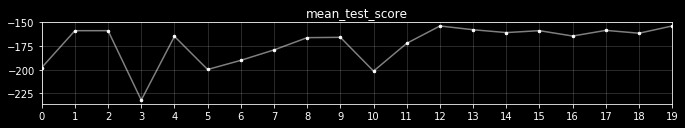

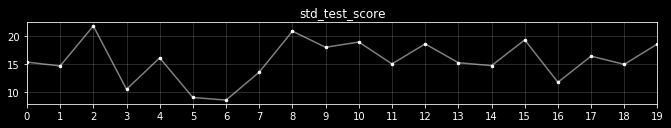

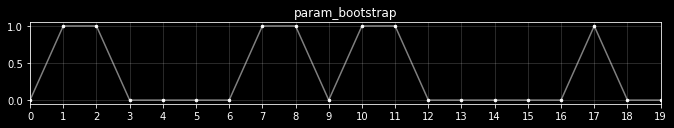

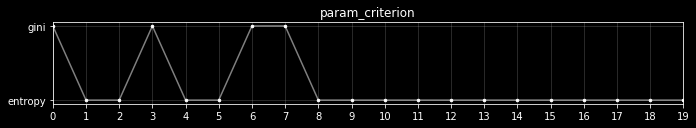

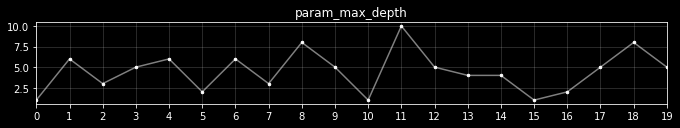

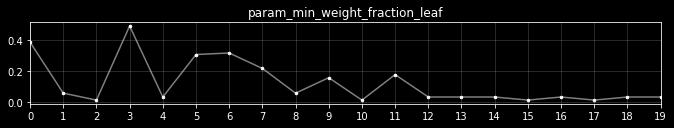

In [5]:
# --- Bayesian Search Convergence Plots -----------------------------------------
res.sort_index(inplace=True)
for col in res.iloc[:,1:-5].columns.values:
    fig = plt.figure(figsize=[11.3, 1.5])
    plt.plot(res.index.values, res[col].values, '.', color='w', markersize=5)
    plt.plot(res.index.values, res[col].values, '-', color='w', alpha=0.5)
    plt.title(col)
    plt.xlim([0, iterations-1])
    plt.xticks(range(0, iterations))
    plt.grid(True, alpha=0.2)
    plt.show()

In [6]:
# --- Recursive Feature Elimination ---------------------------------------------******************************
pd.options.display.float_format = '{:.3g}'.format

for n_features in range(1, len(feature_names)+1):
    
    # Setting up the selector
    selector = RFE(hps.best_estimator_, n_features_to_select=n_features)
    
    # Fitting selector
    selector = selector.fit(X_train, y_train)
    
    # Harvesting selected feature rankings
    rank = pd.Series(data=selector.ranking_, name='cost', index=feature_names)
    
    # Masks will be used to find the selected features and create the hold-set
    masks = [0 if mask==False else 1 for mask in selector.support_.tolist()]
    masks = pd.Series(data=masks, name='accu', index=feature_names)
    
    # Results dataframe
    res = pd.concat([rank, masks], axis=1).sort_values(['cost'])
    res['cost'] = res.index.values
    res.reset_index(inplace=True, drop=True)
    res = res.T
    
    # Finding selected features with mask values
    cols = []
    for j in res.columns:
        if res.loc['accu', j] == 1:
            cols.append(res.loc['cost', j])
        else:
            res.loc['cost', j] = '-'
            
    # Creating the new hold-out set with only the selected features
    X_tr, X_te, y_tr, y_te = train_test_split(df[cols].values, y, 
                                              random_state=2018)
    '''
    [Note] Different set names have been used so that they do not replace the
           original training and hold-sets that were created earlier
    '''
    # Training RFC with only the selected features
    model = hps.best_estimator_.fit(X_tr, y_tr)
    
    # Getting predictions
    y_pr = model.predict(X_te)
    
    # Computing hold-out set cost and accuracy
    cost = custom_cost_function(y_te, y_pr)
    accu = metrics.accuracy_score(y_te, y_pr)
    
    # Attaching hold-out set results to results dataframe
    test = pd.DataFrame(data=[cost, accu], index=['cost', 'accu'], 
                        columns=['TEST'])
    print pd.concat([test, res], axis=1)
    print

      TEST    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cost  -170  CHK  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
accu 0.608    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

      TEST    0    1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cost  -213  CHK  TPR  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
accu 0.628    1    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

      TEST    0    1    2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cost  -232  CHK  MSR  TPR  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
accu   0.6    1    1    1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

      TEST    0    1    2    3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
cos

      TEST    0     1      2         3         4        5    6    7    8    9   10   11   12   13   14   15  \
cost  -190  DUR  owns  rents  deb_none  car_used  car_new  TEL  OIP  PPT  SEX  SAV  EXP  CHK  IN1  TPR  MSR   
accu 0.688    1     1      1         1         1        1    1    1    1    1    1    1    1    1    1    1   

       16   17   18   19   20   21       22 23 24 25 26 27  
cost  CRD  AGE  RES  INR  AMT  HIS  skilled  -  -  -  -  -  
accu    1    1    1    1    1    1        1  0  0  0  0  0  

      TEST    0     1      2         3         4        5    6    7    8    9         10   11   12   13   14  \
cost  -188  DUR  owns  rents  deb_none  car_used  car_new  TEL  OIP  PPT  SEX  unskilled  SAV  EXP  CHK  IN1   
accu 0.664    1     1      1         1         1        1    1    1    1    1          1    1    1    1    1   

       15   16   17   18   19   20   21   22       23 24 25 26 27  
cost  TPR  MSR  CRD  AGE  RES  INR  AMT  HIS  skilled  -  -  -  -  
accu    1

### Conclusion: hold-out set performance cannot be improved with feature elimination

## 4. Custom Datasets (Attempt)
---
Some of the numerical features are using the same original numerical features (AMR, INR, DUR) so here we test to see if not including the duplicated pieces of information about a record will yield better hold-out set performance:
- Set 1: AMT, DUR, INR, TPR, IN1 Removed MSR and everything else stays
- Set 2: AMT, DUR, INR, MPR, IN1 Removed TPR and everything else stays
- Set 2: AMT, INR, MSR, TPR Removed IN1 and everything else stays (DUR not removed as IN1 does not use it)
- Set 2: No new numerical features (MSR, TPR and IN1 removed)

In [7]:
# --- Testing Routine (HPS and the Hold-Out set scores) -------------------------******************************
def CUSTOM_DF_TEST(cdf):
    '''
    [Description]
    -----------------------------------------------------------------------------
    1. Creates new training and hold-out sets
    2. Conducts Bayesian Hyperparameter Search with new custom dataset
    3. Prints feature importances
    4. Prints hold-out set performance
    
    [Inputs]
    -----------------------------------------------------------------------------
    _________
    custom_df|   [pandas DataFrame]
                 The custom dataframe
                 
    [Outputs]
    -----------------------------------------------------------------------------
    _________
    *list*   |   [list]
                 Contains:
                 - the fitted Bayesian hyperparameter search object
                 - the modified hyperparameter search results dataframe
                 - feature importance dataframe
    '''
    
    # --- Creatign New Training and hold-out sets -------------------------------
    cfeature_names = cdf.columns.tolist()
    X_tr, X_te, y_tr, y_te = train_test_split(cdf.values, y, random_state = 2018)
    
     # --- Bayesian Hyperparameter Search ---------------------------------------
    chps = BSCV(DT_rfc, params, cv=folds, n_iter=iterations, scoring=scoring,
                iid=True, return_train_score=False, random_state=2018)
    chps.fit(X_tr, y_tr)
    winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

    # --- Formating Hyperparameter Search Results -------------------------------
    cres = pd.DataFrame(chps.cv_results_)
    a = cres[['mean_test_score', 'std_test_score']]
    cres.drop(['mean_test_score', 'std_test_score', 'params', 'mean_fit_time', 
               'mean_score_time', 'std_fit_time', 'std_score_time', 
               'rank_test_score'], axis=1, inplace=True)
    total_cost = cres.loc[:, 'split0_test_score']
    for i in range(1, folds):
        total_cost = total_cost + cres.loc[:, 'split{}_test_score'.format(i)]
    total_cost.name = 'total_cost'
    cres = pd.concat([total_cost, a, cres], axis=1)
    cres.sort_values(by=['total_cost'], inplace=True, ascending=False)

    # --- Feature Importance Results --------------------------------------------
    cfeature_imps = pd.DataFrame(data=chps.best_estimator_.feature_importances_,
                                 index=cfeature_names, columns=['impt'])
    pd.options.display.float_format = '{:.2g}'.format
    print cfeature_imps.T

    # --- Hold-Out Set Performance ----------------------------------------------
    y_pr = chps.best_estimator_.predict(X_te)
    pd.options.display.float_format = '{:.4g}'.format
    print '\n', pd.DataFrame(metrics.confusion_matrix(y_te, y_pr),
                             columns = ['Pred Bad', 'Pred Good'],
                             index = ['Actual Bad', 'Actual Good'])
    print '\nHold-Out Set Loss:', custom_cost_function(y_te, y_pr)
    print 'Hold-Out Set Accuracy:', metrics.accuracy_score(y_te, y_pr)
    return [chps, cres, cfeature_imps]

# --- MSR in & AMT, DUR, INR, TPR and IN1 out -----------------------------------
cdf = df.drop(['AMT', 'DUR', 'INR', 'TPR', 'IN1'], axis=1)
print '>>> M S R ----------------------------------------------------------------'
kMSR = CUSTOM_DF_TEST(cdf)

# --- TPR in & AMT, DUR, INR, MSR and IN1 out -----------------------------------
cdf = df.drop(['AMT', 'DUR', 'INR', 'MSR', 'IN1'], axis=1)
print '>>> T P R ----------------------------------------------------------------'
kTPR = CUSTOM_DF_TEST(cdf)

# --- IN1 & DUR in & AMT, INR, MSR and TPR out ----------------------------------
cdf = df.drop(['AMT', 'INR', 'MSR', 'TPR'], axis=1)
print '>>> I N 1 ----------------------------------------------------------------'
kIN1 = CUSTOM_DF_TEST(cdf)

# --- MSR, TPR and IN1 out ------------------------------------------------------
cdf = df.drop(['IN1', 'MSR', 'TPR'], axis=1)
print '>>> N O   N E W   N U M E R I C A L   I N T E R A C T I O N S  -----------'
defu = CUSTOM_DF_TEST(cdf)

>>> M S R ----------------------------------------------------------------
      RES   AGE   CRD  PPL  MSR  CHK   HIS  SAV   EXP   SEX  PPT   OIP  TEL  FRN  car_new  car_used  deb_none  \
impt    0 0.068 0.014    0 0.15 0.16 0.055 0.16 0.027 0.014 0.12 0.082    0    0    0.041     0.014     0.014   

      deb_coap  rents  owns  unemp  unskilled  skilled  
impt         0      0 0.068      0          0        0  

             Pred Bad  Pred Good
Actual Bad         59         23
Actual Good        68        100

Hold-Out Set Loss: -183
Hold-Out Set Accuracy: 0.636
>>> T P R ----------------------------------------------------------------
        RES   AGE   CRD    PPL  TPR  CHK   HIS  SAV   EXP   SEX   PPT  OIP    TEL    FRN  car_new  car_used  \
impt 0.0075 0.043 0.014 0.0054  0.2  0.3 0.047 0.11 0.044 0.023 0.051 0.04 0.0023 0.0077    0.027     0.031   

      deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
impt     0.004    0.0017  0.009 0.019 0.0013     0.0071   0.0014 

### Conclusion: None of the custom datasets are improving the hold-out accraucy either

## 5. Preprocessing: Scaling features
---

In [8]:
# Unscaled data
pd.options.display.float_format = '{:5.2f}'.format
print df.describe().iloc[[1,2,3,7],:], '\n'

       DUR      AMT   INR   RES   AGE   CRD   PPL    MSR      TPR    IN1   CHK   HIS   SAV   EXP   SEX   PPT  \
mean 20.90  3271.26  2.97  2.85 35.55  1.41  1.16  92.10  2469.32  88.70  2.58  2.54  2.10  3.38  2.68  2.36   
std  12.06  2822.74  1.12  1.10 11.38  0.58  0.36 131.56  3623.67  79.48  1.26  1.08  1.58  1.21  0.71  1.05   
min   4.00   250.00  1.00  1.00 19.00  1.00  1.00   1.53    24.04   5.00  1.00  0.00  1.00  1.00  1.00  1.00   
max  72.00 18424.00  4.00  4.00 75.00  4.00  2.00 957.96 33664.80 572.72  4.00  4.00  5.00  5.00  4.00  4.00   

       OIP   TEL   FRN  car_new  car_used  deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
mean  2.67  1.40  1.04     0.23      0.10      0.91      0.04   0.18  0.71   0.02       0.20     0.63  
std   0.71  0.49  0.19     0.42      0.30      0.29      0.20   0.38  0.45   0.15       0.40     0.48  
min   1.00  1.00  1.00     0.00      0.00      0.00      0.00   0.00  0.00   0.00       0.00     0.00  
max   3.00  2.00  2.00 

In [9]:
print '>>> MinMax ---------------------------------------------------------------'
X_minmax = MinMaxScaler().fit_transform(df.values)
df_minmax = pd.DataFrame(data=X_minmax, columns=df.columns)
print df_minmax.describe().iloc[[1,2,3,7],:], '\n'

>>> MinMax ---------------------------------------------------------------
       DUR   AMT   INR   RES   AGE   CRD   PPL   MSR   TPR   IN1   CHK   HIS   SAV   EXP   SEX   PPT   OIP  \
mean  0.25  0.17  0.66  0.62  0.30  0.14  0.15  0.09  0.07  0.15  0.53  0.64  0.28  0.60  0.56  0.45  0.84   
std   0.18  0.16  0.37  0.37  0.20  0.19  0.36  0.14  0.11  0.14  0.42  0.27  0.40  0.30  0.24  0.35  0.35   
min   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
max   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   

       TEL   FRN  car_new  car_used  deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
mean  0.40  0.04     0.23      0.10      0.91      0.04   0.18  0.71   0.02       0.20     0.63  
std   0.49  0.19     0.42      0.30      0.29      0.20   0.38  0.45   0.15       0.40     0.48  
min   0.00  0.00     0.00      0.00      0.00      0.00   0.00  0.00   0.00     

In [10]:
print '>>> StandardScaler -------------------------------------------------------'
X_normalized = StandardScaler().fit_transform(df.values)
df_normalized = pd.DataFrame(data=X_normalized, columns=df.columns)
print df_normalized.describe().iloc[[1,2,3,7],:], '\n'

>>> StandardScaler -------------------------------------------------------
       DUR   AMT   INR   RES   AGE   CRD   PPL   MSR   TPR   IN1   CHK   HIS   SAV   EXP   SEX   PPT   OIP  \
mean  0.00  0.00  0.00 -0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00 -0.00 -0.00 -0.00  0.00  0.00 -0.00  0.00   
std   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   
min  -1.40 -1.07 -1.76 -1.67 -1.46 -0.70 -0.43 -0.69 -0.68 -1.05 -1.25 -2.35 -0.70 -1.97 -2.38 -1.29 -2.38   
max   4.24  5.37  0.92  1.05  3.47  4.49  2.33  6.59  8.61  6.09  1.13  1.34  1.83  1.34  1.86  1.56  0.46   

       TEL   FRN  car_new  car_used  deb_none  deb_coap  rents  owns  unemp  unskilled  skilled  
mean -0.00  0.00     0.00      0.00      0.00      0.00   0.00  0.00  -0.00      -0.00    -0.00  
std   1.00  1.00     1.00      1.00      1.00      1.00   1.00  1.00   1.00       1.00     1.00  
min  -0.82 -0.20    -0.55     -0.34     -3.12     -0.21  -0.47 -1.58  -0.15     

In [11]:
# --- Creating Ordinal Dictionaries (for later reference) -----------------------
ordinals = ('CHK', 'HIS', 'SAV', 'EXP', 'SEX', 'PPT', 'OIP')
ordi_dicts = {}
for col in ordinals:
    index = doc[col].value_counts().index.tolist()
    a = df[col].value_counts().index.tolist()
    b = df_minmax[col].value_counts().index.tolist()
    c = df_normalized[col].value_counts().index.tolist()
    d = df[col].value_counts().values.tolist()
    dict_i = pd.DataFrame({col+'_rank': a, 'minmax': b, 'normalized':c, 'count': d})
    dict_i.index = index
    dict_i = dict_i[[col+'_rank', 'minmax', 'normalized', 'count']]
    dict_i.sort_values(col+'_rank', inplace=True)
    ordi_dicts[col] = dict_i
    
# Sample dictionary
print ">>> Sample Dictionary {'CHK'}"
print ordi_dicts['CHK']

# --- Pickling ------------------------------------------------------------------
# with open('feature_names.pkl','wb') as my_file:
#     pickle.dump(feature_names, my_file)

# with open('ordinal_dicts.pkl','wb') as my_file:
#     pickle.dump(ordi_dicts, my_file)
    
# with open('unscaled_dataset.pkl','wb') as my_file:
#     pickle.dump(df.values, my_file)

# with open('normalized_dataset.pkl','wb') as my_file:
#     X_normalized = StandardScaler().fit_transform(df.values)
#     pickle.dump(X_normalized, my_file)

# with open('minmax_dataset.pkl','wb') as my_file:
#     X_minmax = MinMaxScaler().fit_transform(df.values)
#     pickle.dump(X_minmax, my_file)

>>> Sample Dictionary {'CHK'}
     CHK_rank  minmax  normalized  count
A11         1    0.00       -1.25    274
A12         2    0.33       -0.46    269
A13         3    0.67        0.34     63
A14         4    1.00        1.13    394


## 6. Tuning Classifiers
---

In [12]:
# --- Defining routine (Hyperparameter Search and Hold-Out set test) ------------
def RUN_HPS(X, y, clf, param, iters, name, folds=3, mode='custom', sam_wei=None):
    '''
    [Description]
    -----------------------------------------------------------------------------
    Runs Bayesian Hyperparameter Search (HPS) to tune the selected classifiers.
    
    [Inputs]
    -----------------------------------------------------------------------------
    ________
    X       |   [list]
                Features
    ________
    y       |   [list]
                Labels
    ________
    clf     |   [sklearn classifier object]
                The classifier object that is to be tuned and test
    ________
    param   |   [dictionary]
                Hyperparameters to tune
    ________
    iters   |   [integer]
                Number of iterations allocated for the Bayesian Search
    ________
    name    |   [string]
                Name of the classifier
    ________
    folds   |   [integer] Default = 3
                Number of folds for cross-validation
    ________
    mode    |   [string] Default = 'custom'
                The metric for which the Bayesian Hyperparameter search will
                tune to optimize. Either 'custom' (custom cost function) or
                'roc_auc'
    ________
    sam_wei |   [list] Default = None
                Sample weights. Some sklearn classifiers do not have a
                class_weight parameter however they all do have sample_weights.
                If specified, sample weights will be fed into the Bayesian Search
                
    [Outputs]
    -----------------------------------------------------------------------------
    ____________
    *estimator* |   [fitted sklearn classifier object]
                    The tuned classifier that the Bayesian Hyperparameter Search
                    has produced
    ____________
    cm          |   [pandas Series]
                    Contains confusion matrix elements in this order:
                    - False Positive
                    - False Negative
                    - True Positive
                    - True Negative
                    Name of the series is the name passed into the funciton
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018)
    
    if mode == 'custom':
        func = cost_function
    elif mode == 'roc_auc':
        func = 'roc_auc'
        
    # Bayesian hyperparameter search
    if sam_wei == None:
        hps = BSCV(clf, param, cv=folds, n_iter=iters, scoring=func, iid=True, 
                   return_train_score=False, random_state=2018)
        hps.fit(X_train, y_train)
    else:
        hps = BSCV(clf, param, cv=folds, n_iter=iters, scoring=func, iid=True, 
                   return_train_score=False, random_state=2018, 
                   fit_params=sam_wei)
        hps.fit(X_train, y_train)
    winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)
    
    # Hold-Out set performance metrics
    y_pred = hps.best_estimator_.predict(X_test)
    COST = custom_cost_function(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    
    # Hold-out set confusion matrix
    cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                      columns = ['Pred Bad', 'Pred Good'],
                      index = ['Actual Bad', 'Actual Good'])
    TN = cm.loc['Actual Bad', 'Pred Bad']
    FP = cm.loc['Actual Bad', 'Pred Good']
    TP = cm.loc['Actual Good', 'Pred Good']
    FN = cm.loc['Actual Good', 'Pred Bad']
    cm = pd.Series(data={'FP':FP, 'FN':FN, 'TP':TP, 'TN':TN}, name=name)
    print '{} |{:4g} |{:4g} |{:4g} |{:4g} |{:6g}  |{:7.3f}  |'.format(name, FP, 
                                                                      FN, TP, TN,
                                                                      COST, ACC)
    return hps.best_estimator_, cm

In [ ]:
# --- Defining Hyperparameters for each classifier
cs = 100 # cache_size

# Declaring Hyperparameters for every type of classifier
parSL = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'fit_intercept': Categorical([True, False])}
parSX = {'gamma': Real(1e-6, 1e+6, prior='log-uniform'),
         'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'shrinking': Categorical([True, False])}
parLR = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'fit_intercept': Categorical([True, False])}
parDT = {'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
         'max_depth': Integer(1, 10)}
parGB = {'learning_rate': Categorical(np.arange(0.0, 1.0005, 0.0005)),
         'n_estimators': Integer(1, 100),
         'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
         'max_depth': Integer(1, 10)}
parRA = {'random_state': Categorical([5482, 46, 77, 2017, 2018, 25, 4]),
         'n_estimators': Integer(1, 100),
         'min_weight_fraction_leaf': Categorical(np.arange(0.0, 0.505, 0.005)),
         'max_depth': Integer(1, 10)}

##### Normalized Dataset
---

In [260]:
# --- Normalized datased: Balanced ----------------------------------------------

cw = 'balanced' # class_weight
X = StandardScaler().fit_transform(df.values)
BE_bal_n = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_n = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_bal_n = BE_bal_n.set_value(names[i], model)
    CM_bal_n = CM_bal_n.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_bal_n = BE_bal_n.set_value(names[i], model)
    CM_bal_n = CM_bal_n.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_bal_n = BE_bal_n.set_value(names[i], model)
    CM_bal_n = CM_bal_n.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  20 |  64 | 104 |  62 |  -164  |  0.664  |
SL_l2s_n |  20 |  63 | 105 |  62 |  -163  |  0.668  |
SL_l2h_n |  18 |  64 | 104 |  64 |  -154  |  0.672  |
SX_po2_n |  38 |  62 | 106 |  44 |  -252  |  0.600  |
SX_po3_n |  36 |  33 | 135 |  46 |  -213  |  0.724  |
SX_rbf_n |  25 |  52 | 116 |  57 |  -177  |  0.692  |
SX_sig_n |  25 |  53 | 115 |  57 |  -178  |  0.688  |
LR_l1s_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_l1l_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_l2s_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_l2l_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_nwt_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_lbf_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |
LR_sag_n |  20 |  61 | 107 |  62 |  -161  |  0.676  |


In [282]:
# --- Normalized dataset: Imbalanced --------------------------------------------

cw = None # class_weight
X = StandardScaler().fit_transform(df.values)
BE_imb_n = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_n = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_imb_n = BE_imb_n.set_value(names[i], model)
    CM_imb_n = CM_imb_n.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_imb_n = BE_imb_n.set_value(names[i], model)
    CM_imb_n = CM_imb_n.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_imb_n = BE_imb_n.set_value(names[i], model)
    CM_imb_n = CM_imb_n.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  22 |  64 | 104 |  60 |  -174  |  0.656  |
SL_l2s_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
SL_l2h_n |  20 |  64 | 104 |  62 |  -164  |  0.664  |
SX_po2_n |  42 |  44 | 124 |  40 |  -254  |  0.656  |
SX_po3_n |  43 |  40 | 128 |  39 |  -255  |  0.668  |
SX_rbf_n |  40 |  39 | 129 |  42 |  -239  |  0.684  |
SX_sig_n |  43 |  17 | 151 |  39 |  -232  |  0.760  |
LR_l1s_n |  22 |  65 | 103 |  60 |  -175  |  0.652  |
LR_l1l_n |  22 |  66 | 102 |  60 |  -176  |  0.648  |
LR_l2s_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_l2l_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_nwt_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_lbf_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |
LR_sag_n |  20 |  58 | 110 |  62 |  -158  |  0.688  |


In [289]:
# --- Normalized datased: Balanced -X--------------------------------------------

cw = 'balanced' # class_weight
X = StandardScaler().fit_transform(df.values)
BE_bal_n_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_n_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_bal_n_roc = BE_bal_n_roc.set_value(names[i], model)
    CM_bal_n_roc = CM_bal_n_roc.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_bal_n_roc = BE_bal_n_roc.set_value(names[i], model)
    CM_bal_n_roc = CM_bal_n_roc.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_bal_n_roc = BE_bal_n_roc.set_value(names[i], model)
    CM_bal_n_roc = CM_bal_n_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  21 |  61 | 107 |  61 |  -166  |  0.672  |
SL_l2s_n |  22 |  57 | 111 |  60 |  -167  |  0.684  |
SL_l2h_n |  26 |  53 | 115 |  56 |  -183  |  0.684  |
SX_po2_n |  39 |  51 | 117 |  43 |  -246  |  0.640  |
SX_po3_n |  39 |  35 | 133 |  43 |  -230  |  0.704  |
SX_rbf_n |  26 |  53 | 115 |  56 |  -183  |  0.684  |
SX_sig_n |  25 |  54 | 114 |  57 |  -179  |  0.684  |
LR_l1s_n |  27 |  47 | 121 |  55 |  -182  |  0.704  |
LR_l1l_n |  26 |  48 | 120 |  56 |  -178  |  0.704  |
LR_l2s_n |  26 |  44 | 124 |  56 |  -174  |  0.720  |
LR_l2l_n |  21 |  57 | 111 |  61 |  -162  |  0.688  |
LR_nwt_n |  26 |  45 | 123 |  56 |  -175  |  0.716  |
LR_lbf_n |  26 |  45 | 123 |  56 |  -175  |  0.716  |
LR_sag_n |  26 |  44 | 124 |  56 |  -174  |  0.720  |


In [290]:
# --- Normalized dataset: Imbalanced -X------------------------------------------

cw = None # class_weight
X = StandardScaler().fit_transform(df.values)
BE_imb_n_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_n_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_n', 'SL_l2s_n', 'SL_l2h_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_imb_n_roc = BE_imb_n_roc.set_value(names[i], model)
    CM_imb_n_roc = CM_imb_n_roc.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_n', 'SX_po3_n', 'SX_rbf_n', 'SX_sig_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_imb_n_roc = BE_imb_n_roc.set_value(names[i], model)
    CM_imb_n_roc = CM_imb_n_roc.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_n', 'LR_l1l_n', 'LR_l2s_n', 'LR_l2l_n', 
         'LR_nwt_n', 'LR_lbf_n', 'LR_sag_n')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_imb_n_roc = BE_imb_n_roc.set_value(names[i], model)
    CM_imb_n_roc = CM_imb_n_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_n |  41 |  20 | 148 |  41 |  -225  |  0.756  |
SL_l2s_n |  38 |  22 | 146 |  44 |  -212  |  0.760  |
SL_l2h_n |  20 |  65 | 103 |  62 |  -165  |  0.660  |
SX_po2_n |  54 |  16 | 152 |  28 |  -286  |  0.720  |
SX_po3_n |  46 |  24 | 144 |  36 |  -254  |  0.720  |
SX_rbf_n |  78 |   1 | 167 |   4 |  -391  |  0.684  |
SX_sig_n |  82 |   0 | 168 |   0 |  -410  |  0.672  |
LR_l1s_n |  45 |  20 | 148 |  37 |  -245  |  0.740  |
LR_l1l_n |  43 |  22 | 146 |  39 |  -237  |  0.740  |
LR_l2s_n |  43 |  18 | 150 |  39 |  -233  |  0.756  |
LR_l2l_n |  39 |  23 | 145 |  43 |  -218  |  0.752  |
LR_nwt_n |  49 |  16 | 152 |  33 |  -261  |  0.740  |
LR_lbf_n |  49 |  17 | 151 |  33 |  -262  |  0.736  |
LR_sag_n |  48 |  18 | 150 |  34 |  -258  |  0.736  |


##### MinMax Datasets
---

In [283]:
# --- MinMax dataset: Balanced ------------------------------------------------------------

cw = 'balanced' # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_bal_m = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_m = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_bal_m = BE_bal_m.set_value(names[i], model)
    CM_bal_m = CM_bal_m.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_bal_m = BE_bal_m.set_value(names[i], model)
    CM_bal_m = CM_bal_m.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_bal_m = BE_bal_m.set_value(names[i], model)
    CM_bal_m = CM_bal_m.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |  25 |  48 | 120 |  57 |  -173  |  0.708  |
SL_l2s_m |  26 |  53 | 115 |  56 |  -183  |  0.684  |
SL_l2h_m |  28 |  53 | 115 |  54 |  -193  |  0.676  |
SX_po2_m |  19 |  72 |  96 |  63 |  -167  |  0.636  |
SX_po3_m |  19 |  73 |  95 |  63 |  -168  |  0.632  |
SX_rbf_m |  23 |  52 | 116 |  59 |  -167  |  0.700  |
SX_sig_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_l1s_m |  26 |  49 | 119 |  56 |  -179  |  0.700  |
LR_l1l_m |  26 |  48 | 120 |  56 |  -178  |  0.704  |
LR_l2s_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_l2l_m |  27 |  51 | 117 |  55 |  -186  |  0.688  |
LR_nwt_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_lbf_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_sag_m |  27 |  51 | 117 |  55 |  -186  |  0.688  |


In [286]:
# --- MinMax dataset: Imbalanced ------------------------------------------------

cw = None # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_imb_m = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_m = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i])
    BE_imb_m = BE_imb_m.set_value(names[i], model)
    CM_imb_m = CM_imb_m.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i])
    BE_imb_m = BE_imb_m.set_value(names[i], model)
    CM_imb_m = CM_imb_m.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i])
    BE_imb_m = BE_imb_m.set_value(names[i], model)
    CM_imb_m = CM_imb_m.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |   0 | 168 |   0 |  82 |  -168  |  0.328  |
SL_l2s_m |  39 |  23 | 145 |  43 |  -218  |  0.752  |
SL_l2h_m |  40 |  25 | 143 |  42 |  -225  |  0.740  |
SX_po2_m |  33 |  34 | 134 |  49 |  -199  |  0.732  |
SX_po3_m |  38 |  29 | 139 |  44 |  -219  |  0.732  |
SX_rbf_m |  42 |  27 | 141 |  40 |  -237  |  0.724  |
SX_sig_m |  37 |  26 | 142 |  45 |  -211  |  0.748  |
LR_l1s_m |   0 | 168 |   0 |  82 |  -168  |  0.328  |
LR_l1l_m |   0 | 168 |   0 |  82 |  -168  |  0.328  |
LR_l2s_m |  41 |  24 | 144 |  41 |  -229  |  0.740  |
LR_l2l_m |  41 |  24 | 144 |  41 |  -229  |  0.740  |
LR_nwt_m |  41 |  24 | 144 |  41 |  -229  |  0.740  |
LR_lbf_m |  38 |  24 | 144 |  44 |  -214  |  0.752  |
LR_sag_m |  38 |  24 | 144 |  44 |  -214  |  0.752  |


In [291]:
# --- MinMax dataset: Balanced -X----------------------------------------------------------

cw = 'balanced' # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_bal_m_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_m_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_bal_m_roc = BE_bal_m_roc.set_value(names[i], model)
    CM_bal_m_roc = CM_bal_m_roc.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_bal_m_roc = BE_bal_m_roc.set_value(names[i], model)
    CM_bal_m_roc = CM_bal_m_roc.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_bal_m_roc = BE_bal_m_roc.set_value(names[i], model)
    CM_bal_m_roc = CM_bal_m_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |  25 |  49 | 119 |  57 |  -174  |  0.704  |
SL_l2s_m |  26 |  50 | 118 |  56 |  -180  |  0.696  |
SL_l2h_m |  27 |  52 | 116 |  55 |  -187  |  0.684  |
SX_po2_m |  21 |  57 | 111 |  61 |  -162  |  0.688  |
SX_po3_m |  19 |  72 |  96 |  63 |  -167  |  0.636  |
SX_rbf_m |  23 |  52 | 116 |  59 |  -167  |  0.700  |
SX_sig_m |  27 |  54 | 114 |  55 |  -189  |  0.676  |
LR_l1s_m |  26 |  48 | 120 |  56 |  -178  |  0.704  |
LR_l1l_m |  27 |  46 | 122 |  55 |  -181  |  0.708  |
LR_l2s_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_l2l_m |  27 |  51 | 117 |  55 |  -186  |  0.688  |
LR_nwt_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_lbf_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |
LR_sag_m |  26 |  51 | 117 |  56 |  -181  |  0.692  |


In [292]:
# --- MinMax dataset: Imbalanced -X----------------------------------------------

cw = None # class_weight
X = MinMaxScaler().fit_transform(df.values)
BE_imb_m_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_m_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Linear SVC ---------------------------------------------------------------#
#################################################################################
SL_l1s = LinearSVC(class_weight=cw, random_state=2018, penalty='l1', dual=False)
SL_l2s = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', dual=False)
SL_l2h = LinearSVC(class_weight=cw, random_state=2018, penalty='l2', loss='hinge')

clfs = (SL_l1s, SL_l2s, SL_l2h)
names = ('SL_l1s_m', 'SL_l2s_m', 'SL_l2h_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSL, 20, names[i], mode='roc_auc')
    BE_imb_m_roc = BE_imb_m_roc.set_value(names[i], model)
    CM_imb_m_roc = CM_imb_m_roc.append(matrix)

#################################################################################
# --- Non-linear SVCs ----------------------------------------------------------#
#################################################################################
SX_po2 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=2)
SX_po3 = SVC(class_weight=cw, cache_size=cs, kernel='poly', degree=3)
SX_rbf = SVC(class_weight=cw, cache_size=cs, kernel='rbf')
SX_sig = SVC(class_weight=cw, cache_size=cs, kernel='sigmoid')

clfs = (SX_po2, SX_po3, SX_rbf, SX_sig)
names = ('SX_po2_m', 'SX_po3_m', 'SX_rbf_m', 'SX_sig_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parSX, 20, names[i], mode='roc_auc')
    BE_imb_m_roc = BE_imb_m_roc.set_value(names[i], model)
    CM_imb_m_roc = CM_imb_m_roc.append(matrix)
    
#################################################################################
# --- Logistic Regression ------------------------------------------------------#
#################################################################################
LR_l1s = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='saga')
LR_l1l = LRC(class_weight=cw, n_jobs=-1, penalty='l1', solver='liblinear',
             random_state=2018)
LR_l2s = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='saga')
LR_l2l = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='liblinear',
             random_state=2018, dual=False)
LR_nwt = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='newton-cg')
LR_lbf = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='lbfgs')
LR_sag = LRC(class_weight=cw, n_jobs=-1, penalty='l2', solver='sag',
             random_state=2018)

clfs = (LR_l1s, LR_l1l, LR_l2s, LR_l2l, LR_nwt, LR_lbf, LR_sag)
names = ('LR_l1s_m', 'LR_l1l_m', 'LR_l2s_m', 'LR_l2l_m', 
         'LR_nwt_m', 'LR_lbf_m', 'LR_sag_m')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parLR, 20, names[i], mode='roc_auc')
    BE_imb_m_roc = BE_imb_m_roc.set_value(names[i], model)
    CM_imb_m_roc = CM_imb_m_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
SL_l1s_m |  40 |  22 | 146 |  42 |  -222  |  0.752  |
SL_l2s_m |  41 |  22 | 146 |  41 |  -227  |  0.748  |
SL_l2h_m |  35 |  28 | 140 |  47 |  -203  |  0.748  |
SX_po2_m |  48 |  25 | 143 |  34 |  -265  |  0.708  |
SX_po3_m |  54 |  21 | 147 |  28 |  -291  |  0.700  |
SX_rbf_m |  40 |  27 | 141 |  42 |  -227  |  0.732  |
SX_sig_m |  82 |   0 | 168 |   0 |  -410  |  0.672  |
LR_l1s_m |  39 |  22 | 146 |  43 |  -217  |  0.756  |
LR_l1l_m |  39 |  22 | 146 |  43 |  -217  |  0.756  |
LR_l2s_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_l2l_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_nwt_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_lbf_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |
LR_sag_m |  42 |  18 | 150 |  40 |  -228  |  0.760  |


##### Unscaled Dataset
---

In [273]:
# --- Unscaled dataset: Balanced ------------------------------------------------

cw = 'balanced' # class_weight
X = df.values
BE_bal_u = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_u = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Stand Alone Decision Trees -----------------------------------------------#
#################################################################################
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')

clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i])
    BE_bal_u = BE_bal_u.set_value(names[i], model)
    CM_bal_u = CM_bal_u.append(matrix)

#################################################################################
# --- Gradient Boosted Decision Trees ------------------------------------------#
#################################################################################
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')

clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')

# Making Sample Weights
_, _, y_train, _ = train_test_split(X, y, random_state=2018)
weights = []
for sam in y_train:
    if sam == 0:
        weights.append(float(500)/300)
    else:
        weights.append(float(500)/700)
w = {'sample_weight':weights}

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i], sam_wei=w)
    BE_bal_u = BE_bal_u.set_value(names[i], model)
    CM_bal_u = CM_bal_u.append(matrix)

#################################################################################
# Random Forests and Extremely Randomized Trees --------------------------------#
#################################################################################
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')

clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i])
    BE_bal_u = BE_bal_u.set_value(names[i], model)
    CM_bal_u = CM_bal_u.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  18 |  80 |  88 |  64 |  -170  |  0.608  |
DT_ent_u |  18 |  80 |  88 |  64 |  -170  |  0.608  |
GB_dev_u |  46 |  38 | 130 |  36 |  -268  |  0.664  |
GB_exp_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |
RB_gin_u |  26 |  50 | 118 |  56 |  -180  |  0.696  |
RB_ent_u |  29 |  53 | 115 |  53 |  -198  |  0.672  |
RX_gin_u |  28 |  61 | 107 |  54 |  -201  |  0.644  |
RX_ent_u |  24 |  57 | 111 |  58 |  -177  |  0.676  |
EB_gin_u |  23 |  58 | 110 |  59 |  -173  |  0.676  |
EB_ent_u |  18 |  71 |  97 |  64 |  -161  |  0.644  |
EX_gin_u |  23 |  58 | 110 |  59 |  -173  |  0.676  |
EX_ent_u |  18 |  71 |  97 |  64 |  -161  |  0.644  |


In [288]:
# --- Unscaled dataset: Imbalanced ----------------------------------------------

cw = None # class_weight
X = df.values
BE_imb_u = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_u = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Stand Alone Decision Trees -----------------------------------------------#
#################################################################################
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')

clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i])
    BE_imb_u = BE_imb_u.set_value(names[i], model)
    CM_imb_u = CM_imb_u.append(matrix)

#################################################################################
# --- Gradient Boosted Decision Trees ------------------------------------------#
#################################################################################
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')

clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i])
    BE_imb_u = BE_imb_u.set_value(names[i], model)
    CM_imb_u = CM_imb_u.append(matrix)

#################################################################################
# Random Forests and Extremely Randomized Trees --------------------------------#
#################################################################################
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')

clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i])
    BE_imb_u = BE_imb_u.set_value(names[i], model)
    CM_imb_u = CM_imb_u.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  44 |  41 | 127 |  38 |  -261  |  0.660  |
DT_ent_u |  44 |  41 | 127 |  38 |  -261  |  0.660  |
GB_dev_u |  46 |  19 | 149 |  36 |  -249  |  0.740  |
GB_exp_u |  44 |  22 | 146 |  38 |  -242  |  0.736  |
RB_gin_u |  61 |  10 | 158 |  21 |  -315  |  0.716  |
RB_ent_u |  52 |  19 | 149 |  30 |  -279  |  0.716  |
RX_gin_u |  56 |  11 | 157 |  26 |  -291  |  0.732  |
RX_ent_u |  51 |  26 | 142 |  31 |  -281  |  0.692  |
EB_gin_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |
EB_ent_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |
EX_gin_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |
EX_ent_u |  50 |  36 | 132 |  32 |  -286  |  0.656  |


In [297]:
# --- Unscaled dataset: Balanced -X----------------------------------------------

cw = 'balanced' # class_weight
X = df.values
BE_bal_u_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_bal_u_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Stand Alone Decision Trees -----------------------------------------------#
#################################################################################
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')

clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i], mode='roc_auc')
    BE_bal_u_roc = BE_bal_u_roc.set_value(names[i], model)
    CM_bal_u_roc = CM_bal_u_roc.append(matrix)

#################################################################################
# --- Gradient Boosted Decision Trees ------------------------------------------#
#################################################################################
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')

clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')

# Making Sample Weights
_, _, y_train, _ = train_test_split(X, y, random_state=2018)
weights = []
for sam in y_train:
    if sam == 0:
        weights.append(float(500)/300)
    else:
        weights.append(float(500)/700)
w = {'sample_weight':weights}

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i], sam_wei=w, mode='roc_auc')
    BE_bal_u_roc = BE_bal_u_roc.set_value(names[i], model)
    CM_bal_u_roc = CM_bal_u_roc.append(matrix)

#################################################################################
# Random Forests and Extremely Randomized Trees --------------------------------#
#################################################################################
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')

clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i], mode='roc_auc')
    BE_bal_u_roc = BE_bal_u_roc.set_value(names[i], model)
    CM_bal_u_roc = CM_bal_u_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  31 |  64 | 104 |  51 |  -219  |  0.620  |
DT_ent_u |  18 |  80 |  88 |  64 |  -170  |  0.608  |
GB_dev_u |  44 |  18 | 150 |  38 |  -238  |  0.752  |
GB_exp_u |  46 |  18 | 150 |  36 |  -248  |  0.744  |
RB_gin_u |  28 |  60 | 108 |  54 |  -200  |  0.648  |
RB_ent_u |  25 |  63 | 105 |  57 |  -188  |  0.648  |
RX_gin_u |  24 |  60 | 108 |  58 |  -180  |  0.664  |
RX_ent_u |  27 |  56 | 112 |  55 |  -191  |  0.668  |
EB_gin_u |  22 |  58 | 110 |  60 |  -168  |  0.680  |
EB_ent_u |  25 |  55 | 113 |  57 |  -180  |  0.680  |
EX_gin_u |  22 |  58 | 110 |  60 |  -168  |  0.680  |
EX_ent_u |  25 |  55 | 113 |  57 |  -180  |  0.680  |


In [298]:
# --- Unscaled dataset: Imbalanced -X--------------------------------------------

cw = None # class_weight
X = df.values
BE_imb_u_roc = pd.Series() # Best Estimators with class_weight = 'balanced'
CM_imb_u_roc = pd.DataFrame(columns=['FP','FN','TP','TN']) # Confusion matrix elements

print '   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |'
print '#####################################################'

#################################################################################
# --- Stand Alone Decision Trees -----------------------------------------------#
#################################################################################
DT_gin = DTC(class_weight=cw, random_state=2018, criterion='gini')
DT_ent = DTC(class_weight=cw, random_state=2018, criterion='entropy')

clfs = (DT_gin, DT_ent)
names = ('DT_gin_u', 'DT_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parDT, 20, names[i], mode='roc_auc')
    BE_imb_u_roc = BE_imb_u_roc.set_value(names[i], model)
    CM_imb_u_roc = CM_imb_u_roc.append(matrix)

#################################################################################
# --- Gradient Boosted Decision Trees ------------------------------------------#
#################################################################################
GB_dev = GBC(random_state=2018, loss='deviance')
GB_exp = GBC(random_state=2018, loss='exponential')

clfs = (GB_dev, GB_exp)
names = ('GB_dev_u', 'GB_exp_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parGB, 30, names[i], mode='roc_auc')
    BE_imb_u_roc = BE_imb_u_roc.set_value(names[i], model)
    CM_imb_u_roc = CM_imb_u_roc.append(matrix)

#################################################################################
# Random Forests and Extremely Randomized Trees --------------------------------#
#################################################################################
RB_gin = RFC(class_weight=cw, n_jobs=-1, criterion='gini')
RB_ent = RFC(class_weight=cw, n_jobs=-1, criterion='entropy')
RX_gin = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
RX_ent = RFC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')
EB_gin = ETC(class_weight=cw, n_jobs=-1, criterion='gini')
EB_ent = ETC(class_weight=cw, n_jobs=-1, criterion='entropy')
EX_gin = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='gini')
EX_ent = ETC(class_weight=cw, n_jobs=-1, bootstrap=False, criterion='entropy')

clfs = (RB_gin, RB_ent, RX_gin, RX_ent, EB_gin, EB_ent, EX_gin, EX_ent)
names = ('RB_gin_u', 'RB_ent_u', 'RX_gin_u', 'RX_ent_u', 
         'EB_gin_u', 'EB_ent_u', 'EX_gin_u', 'EX_ent_u')

for i, clf in enumerate(clfs):
    model, matrix = RUN_HPS(X, y, clf, parRA, 25, names[i], mode='roc_auc')
    BE_imb_u_roc = BE_imb_u_roc.set_value(names[i], model)
    CM_imb_u_roc = CM_imb_u_roc.append(matrix)

   MODEL |  FP |  FN |  TP |  TN |  COST  |    ACC  |
#####################################################
DT_gin_u |  49 |  33 | 135 |  33 |  -278  |  0.672  |
DT_ent_u |  49 |  33 | 135 |  33 |  -278  |  0.672  |
GB_dev_u |  48 |  14 | 154 |  34 |  -254  |  0.752  |
GB_exp_u |  51 |  16 | 152 |  31 |  -271  |  0.732  |
RB_gin_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |
RB_ent_u |  78 |   2 | 166 |   4 |  -392  |  0.680  |
RX_gin_u |  51 |  14 | 154 |  31 |  -269  |  0.740  |
RX_ent_u |  67 |   6 | 162 |  15 |  -341  |  0.708  |
EB_gin_u |  56 |  10 | 158 |  26 |  -290  |  0.736  |
EB_ent_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |
EX_gin_u |  56 |  10 | 158 |  26 |  -290  |  0.736  |
EX_ent_u |  82 |   0 | 168 |   0 |  -410  |  0.672  |


In [299]:
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

In [310]:
# --- Loading HPS results -------------------------------------------------------

with open('best_clfs.pkl','rb') as get_results:
    clf_sets = pickle.load(get_results)

with open('names.pkl','rb') as get_results:
    names = pickle.load(get_results)

with open('matrices.pkl','rb') as get_results:
     CM = pickle.load(get_results)

(SL_l1s_n    LinearSVC(C=0.03321495337607938, class_weight=...
SL_l2s_n    LinearSVC(C=0.007088536606967147, class_weight...
SL_l2h_n    LinearSVC(C=0.33470034518499014, class_weight=...
SX_po2_n    SVC(C=0.31519211732312113, cache_size=100, cla...
SX_po3_n    SVC(C=1e-06, cache_size=100, class_weight='bal...
SX_rbf_n    SVC(C=1.5902113942640974, cache_size=100, clas...
SX_sig_n    SVC(C=0.46023349146505216, cache_size=100, cla...
LR_l1s_n    LogisticRegression(C=0.39303783410452536, clas...
LR_l1l_n    LogisticRegression(C=0.4128692424512529, class...
LR_l2s_n    LogisticRegression(C=0.03321495337607938, clas...
LR_l2l_n    LogisticRegression(C=0.03321495337607938, clas...
LR_nwt_n    LogisticRegression(C=0.03321495337607938, clas...
LR_lbf_n    LogisticRegression(C=0.03321495337607938, clas...
LR_sag_n    LogisticRegression(C=0.03321495337607938, clas...
dtype: object, SL_l1s_n    LinearSVC(C=0.03450900016839712, class_weight=...
SL_l2s_n    LinearSVC(C=0.0018683839690247705, class_w

# @@@@@@@@@@@@@@@@@@@@@@@

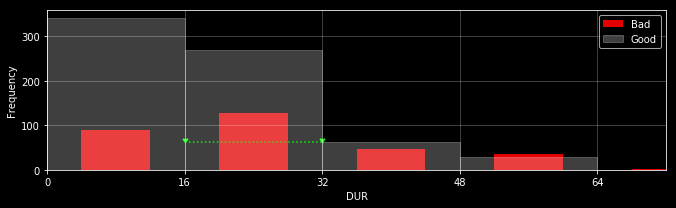

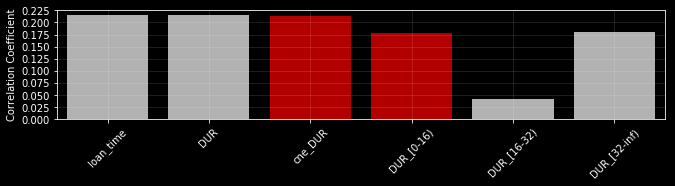

  Feature  Category   Ratio      P(C)  Bad  Good  P(C|B)     P(C|G)     lk_BC      lk_GC  H(C)      H(C,B)    \
0  bin_DUR    [0-16)  19.190476  43.1   89  342   29.666667  48.857143  20.649652  79.35  0.523338  0.310615   
2  bin_DUR   [16-32)  -4.380952  39.6  128  268   42.666667  38.285714  32.323232  67.68  0.529225  0.379620   
1  bin_DUR  [32-inf) -14.809524  17.3   83   90   27.666667  12.857143  47.976879  52.02  0.437890  0.298032   

   H(C,G)    I(C,B)    I(C,G)    
0  0.529393 -0.047957  0.061862  
2  0.509118  0.013774 -0.013050  
1  0.312654  0.056222 -0.038538  


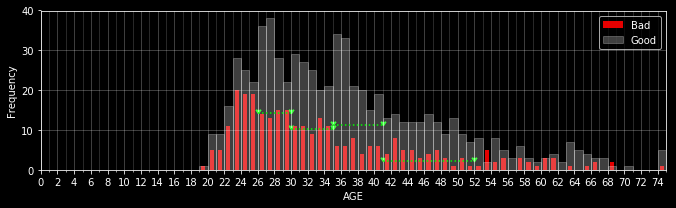

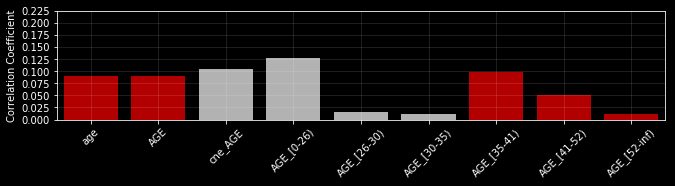

  Feature  Category   Ratio      P(C)  Bad  Good  P(C|B)     P(C|G)     lk_BC      lk_GC  H(C)      H(C,B)    \
3  bin_AGE   [35-41)   8.285714  17.8  36   142   12.000000  20.285714  20.224719  79.78  0.443229  0.172651   
2  bin_AGE   [41-52)   4.142857  16.9  42   127   14.000000  18.142857  24.852071  75.15  0.433469  0.192086   
0  bin_AGE  [52-inf)   0.714286  10.5  30    75   10.000000  10.714286  28.571429  71.43  0.341412  0.151767   
5  bin_AGE   [30-35)  -0.904762  17.7  55   122   18.333333  17.428571  31.073446  68.93  0.442178  0.230143   
4  bin_AGE   [26-30)  -1.285714  18.1  57   124   19.000000  17.714286  31.491713  68.51  0.446335  0.235575   
1  bin_AGE    [0-26) -10.952381  19.0  80   110   26.666667  15.714286  42.105263  57.89  0.455226  0.291508   

   H(C,G)    I(C,B)    I(C,G)    
3  0.399877 -0.020478  0.026779  
2  0.378092 -0.011407  0.013002  
0  0.280272 -0.002112  0.002186  
5  0.370276  0.002790 -0.002720  
4  0.373437  0.003991 -0.003853  
1  0.350287

In [4]:
# [DONE] Old features: DUR and AGE

# DUR (Duration)
DUR = raw['loan_time'].copy()
DUR.name = 'DUR'
configs_1 = {'xdiv':16, 'n':3, 'xmin':0, 'xtick_div':1, 'show':True}
res_DUR = ANALYZE_AND_ASSESS(DUR, 'DUR', configs_1, configs_2, raw['loan_time'], assess=True)
print res_DUR[3]

# AGE
AGE = raw['age'].copy()
AGE.name = 'AGE'
configs_1 = {'xdiv':1, 'n':6, 'xmin':0, 'xtick_div':2, 'show':True}
res_AGE = ANALYZE_AND_ASSESS(AGE, 'AGE', configs_1, configs_2, raw['age'], assess=True)
print res_AGE[3]

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

In [318]:
# Dataset 1 to 3: all features in the same FE format

FEF = {'CON': fe_con, 'CNE': fe_cne, 'OHE': fe_ohe}

nums = feature_names[0:5]
cats = feature_names[5:]
df = {}

for num in ['CON','CNE','OHE']:
    
    # Not differentiating between Ordinals and Nominals
    for cat in ['CNE','OHE']: # cat CON is same as cat CNE
        name = 'ALL_{}_{}'.format(num, cat)
        if num != 'OHE' and cat != 'OHE':
            df[name] = pd.concat([FEF[num][nums], FEF[cat][cats]], axis=1)
        elif num == 'OHE' and cat != 'OHE':
            df[name] = pd.concat([FEF[num].iloc[:,0:24], FEF[cat][cats]], axis=1)
        elif num != 'OHE' and cat == 'OHE':
            df[name] = pd.concat([FEF[num][nums], FEF[cat].iloc[:,24:0]], axis=1)
        else:
            df[name] = fe_ohe.copy()
    
    # Nominals always OHE
    

# DT class_weight (None, 'balanced')

print probs.iloc[24:,10:]*100
winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

    H(C)       H(C,B)     H(C,G)     I(C,B)    I(C,G)   
24  14.443602   4.428493  12.113976 -0.291256   0.366630
25  52.827317  31.668445  49.474768 -1.093428   1.158828
26  41.760440  46.438562  52.287394  1.495202  -1.440388
27   4.428493   1.793157   3.186314  0.030401  -0.028156
28  41.689728  20.434223  34.853840 -0.071746   0.072301
30  38.264414  17.265093  32.065237 -0.415718   0.439866
31  40.924575  19.519934  34.321357 -0.240534   0.247246
32  52.689975  37.343691  51.755814  0.014433  -0.014424
33  52.329131  32.648953  47.362856  0.679891  -0.656509
34  52.943059  20.434223  52.994859 -6.263012  11.674177
35  25.127577   8.621801  21.320265 -0.606143   0.744815
36  50.957260  34.141157  42.775009  3.987362  -3.269130
37  51.176410  39.001077  39.571121  9.662613  -6.456798
38  51.891104  21.609640  49.595614 -4.069675   5.944480
39  30.855903  14.443602  24.353362  0.237689  -0.227807
40  48.544594  43.346892  53.064446  1.487141  -1.423075
41  21.320265  14.443602  11.70

## ---. Feature Engineering Ordinal Features

In [5]:
## [DONE] Initializing different datasets for training based on feature engineering approach

# Continuos format
con_numericals = pd.concat([MSR, TPR, IN1, raw['loan_time'], raw['age']], axis=1)
# Binned format
bin_numericals = pd.concat([res_MSR[0], res_TPR[0], res_IN1[0], res_DUR[0], res_AGE[0]], axis=1) 
# Custom Numerical Encoded format
cne_numericals = pd.concat([res_MSR[1], res_TPR[1], res_IN1[1], res_DUR[1], res_AGE[1]], axis=1) 
# One Hot Encoded format
ohe_numericals = pd.concat([res_MSR[2], res_TPR[2], res_IN1[2], res_DUR[2], res_AGE[2]], axis=1) 
# Probabilities of each bin
prob_numericals = pd.concat([res_MSR[3], res_TPR[3], res_IN1[3], res_DUR[3], res_AGE[3]], axis=0) 

fe_con = con_numericals.copy()
fe_bin = pd.concat([bin_numericals, raw[['n_credits','people']], raw.loc[:,'residence':'foreign']], axis=1)
fe_cne = cne_numericals.copy()
fe_ohe = ohe_numericals.copy()
probs = prob_numericals.copy()

feature_names = ['MSR', 'TPR', 'IN1', 'DUR', 'AGE', # Numericals
                 'CRD', 'PPL', 'RES', 'CHK', 'HIS', 'SAV', 'JOB', 'EXP', # Ordinals
                 'PPT', 'HOU', 'FOR', 'SEX', 'DEB', 'OIP', 'TEL', 'FRN' ]

fe_con.columns = feature_names[0:5]
fe_bin.columns = feature_names
fe_cne.columns = feature_names[0:5]

## Ordinal feature engineering

# Stating which features are being treated as ordinal features
ordinal_features = ['n_credits', 'people', 'residence', 'checking', 'history', 'savings', 'job', 'job_status',
                    'property', 'housing', 'for', 'sex', 'debtor', 'OIP', 'telephone', 'foreign']

# Shortening category names for OHE
dicts = [{'0 to 200':'low', # CHK
          '< 0':'save', 
          '> 201':'high', 
          'none':'none'},
         {'critical':'bad', # HIS
          'delayed':'dely', 
          'fully repaid':'good', 
          'fully repaid here':'here', 
          'repaid':'repd'}, 
         {'101 to 500':'med', # SAV
          '501 to 1000':'high', 
          '<100':'low', 
          '>1000':'rich', 
          'unk_nil':'none'}, 
         {'man/self-em/HQ/off':'boss', # JOB
          'skilled / official':'skll', 
          'unemp / unskill (non-res)':'unem', 
          'unskilled (resident)':'unsk'}, 
         {'1 to less than 4':'low', # EXP
          '4 to less than 7':'med', 
          'less than 1':'entr', 
          'more than 7':'high', 
          'unemployed':'unem'}, 
         {'BSSA/Life':'insu', # PPT
          'Car/Other':'car', 
          'UNK/None':'none', 
          'real estate':'real'}, 
         {'business':'busi', # FOR
          'car_new':'ncar', 
          'car_used':'ucar', 
          'dom_app':'doma', 
          'edu':'edu', 
          'fur_equ':'fueq', 
          'rad_tel':'radt', 
          'repairs':'repa', 
          'retain':'reta'}, 
         {'female':'fem', # SEX
          'male_ds':'m-ds', 
          'male_mw':'m-mw', 
          'male_single':'m-s'}, 
         {'coapplicant':'coap', # DEP
          'guarantor':'guar', 
          'none':'none'}, 
         {'bank':'bank', # OIP
          'none':'none', 
          'stores':'stor'}]
dicts = pd.Series(data=dicts, name='dictionaries',
                  index=['CHK', 'HIS', 'SAV', 'JOB', 'EXP', 'PPT', 'FOR', 'SEX', 'DEB', 'OIP'])
for feature in dicts.index: fe_bin[feature] = fe_bin[feature].map(dicts[feature])

# Creating CNE and probabilities for all ordinal features
prefix = feature_names[5:]
cne_ordinals = pd.DataFrame(columns=[name for name in prefix])
prob_ordinals = pd.DataFrame(columns=['Feature', 'Category', 'Ratio', 'P(C)', 'Bad', 'Good',
                                     'P(C|B)', 'P(C|G)', 'lk_BC', 'lk_GC',
                                      'H(C)', 'H(C,B)', 'H(C,G)', 'I(C,B)', 'I(C,G)'])

for i, feature in enumerate(ordinal_features):
    
    # Conducting Bayesian Analysis
    res = CALCULATE_POSTERIOR_PROB(raw, feature)
    prob_ordinals = pd.concat([prob_ordinals, res], axis=0)
    
    # Transforming ordinals into numeric with likelihoods
    dict_ = dict(zip(res['Category'].values, res['lk_GC'].values))
    cne_ordinals[prefix[i]] = raw[feature].map(dict_)
    
    # One Hot Encoding ordinals
    ohe_feature = pd.get_dummies(fe_bin[prefix[i]], prefix=prefix[i])
    fe_ohe = pd.concat([fe_ohe, ohe_feature], axis=1)
fe_ohe = fe_ohe.drop(['PPL_1','TEL_2','FRN_2'], axis=1)

## Saving all datasets
fe_cne = pd.concat([fe_cne, cne_ordinals], axis=1)
probs = pd.concat([probs, prob_ordinals], axis=0)
probs = probs.reset_index(drop=True)
probs['Feature'] = probs['Feature'].map(dict(zip(probs['Feature'].unique(), feature_names)))
probs = probs.drop([29,84,85], axis=0)

for feature in dicts.index:
    shortened = probs.loc[probs['Feature']==feature, 'Category'].map(dicts[feature])
    probs.loc[probs['Feature']==feature, 'Category'] = shortened

# Entropy, Joint Entropy and Mutual Information Gain
cols = ['H(C)', 'H(C,B)', 'H(C,G)', 'I(C,B)', 'I(C,G)']
entropy = pd.DataFrame(columns = cols)
for f in feature_names:
    entropy.loc[f,:] = probs.loc[probs['Feature']==f, cols].sum()
entropy['H(C,L)'] = entropy['H(C,B)'] + entropy['H(C,G)']
entropy['I(C,L)'] = entropy['I(C,B)'] + entropy['I(C,G)']
entropy.drop(['H(C,B)', 'H(C,G)', 'I(C,B)', 'I(C,G)'], axis = 1, inplace = True)

# Computing Correlation Coefficients of CON, CNE and OHE
corr = [np.corrcoef(fe_con[col].values, raw['default'].values)[0, 1] for col in fe_con.columns]
con_corr = pd.Series(data=corr, index=[col for col in fe_con.columns], name='con')
corr = [np.corrcoef(fe_cne[col].values, raw['default'].values)[0, 1] for col in fe_cne.columns]
cne_corr = pd.Series(data=corr, index=[col for col in fe_cne.columns], name='cne')
corr = [np.corrcoef(fe_ohe[col].values, raw['default'].values)[0, 1] for col in fe_ohe.columns]
ohe_corr = pd.Series(data=corr, index=[col for col in fe_ohe.columns], name='ohe')

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

In [6]:
# [DONE] corr vs new ratio for all categories

index = fe_ohe.columns.tolist()

corr = ohe_corr.values.tolist()
corr = pd.Series(data=corr, name='corr', index=index)

ratio = probs['lk_GC']-probs['lk_BC']
ratio = ratio.tolist()
ratio = pd.Series(data=ratio, name='ratio', index=index)

A = pd.concat([corr, ratio], axis=1)
print A

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

                 corr      ratio    
MSR_[0-18)       0.076405  52.223360
MSR_[18-36)      0.057270  50.000000
MSR_[36-78)      0.026339  44.542727
MSR_[78-222)    -0.020147  36.319204
MSR_[222-inf)   -0.185355  -6.898276
TPR_[0-400)      0.079856  56.223208
TPR_[400-1000)   0.106307  54.364466
TPR_[1000-2200) -0.021852  36.155117
TPR_[2200-5800) -0.045946  31.703659
TPR_[5800-inf)  -0.164637  -2.701351
IN1_[0-39)       0.062582  52.456415
IN1_[39-65)      0.081585  49.801961
IN1_[65-104)    -0.017266  36.896602
IN1_[104-221)   -0.047936  31.400483
IN1_[221-inf)   -0.147502 -10.443881
DUR_[0-16)       0.177583  58.700348
DUR_[16-32)     -0.041050  35.356768
DUR_[32-inf)    -0.179422   4.043121
AGE_[0-26)      -0.127938  59.555281
AGE_[26-30)     -0.015303  50.297929
AGE_[30-35)     -0.010863  42.858571
AGE_[35-41)      0.099264  37.856554
AGE_[41-52)      0.050660  37.018287
AGE_[52-inf)     0.010678  15.784737
CRD_1           -0.045727  57.141429
CRD_2            0.036579  44.742372
C

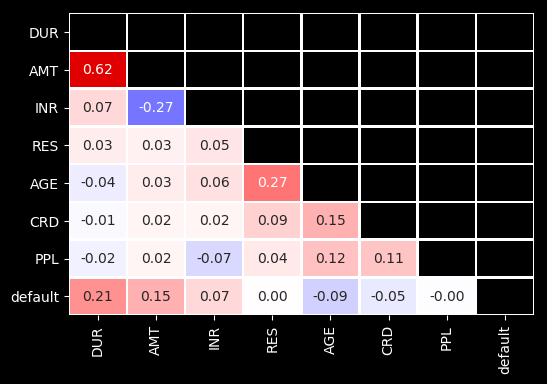

In [181]:
# Investing Missing INR in numeric orignal document

if False:
    caties = ['FOR', 'DEB', 'HOU', 'JOB']
    colies = ['C18', 'C20', 'C22', 'C24']

    for i in (0,1,2,3):
        test = pd.concat([pd.get_dummies(doc[caties[i]]), 
                          don['{}1'.format(caties[i])], don[colies[i]]], axis=1)
        corr = test.corr()
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        
        sns.heatmap(corr.T, annot=True, fmt=".2f", cmap='seismic', square=False,
                    linewidths=1, linecolor='w', vmin=-1, vmax=1, mask=mask, cbar=False)
        plt.yticks(rotation=0)
        plt.xticks(rotation=0)
        plt.show()
    
    for i in (0,1,2,3):
        print caties[i], ':\t', dict(doc[caties[i]].value_counts())
        print colies[i], ':\t', dict(don[colies[i]].value_counts())
        
    test = pd.concat([pd.get_dummies(doc['JOB']),
                      don['JOB1'], don['C24'], don['C25']], axis=1)
    corr = test.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr.T, annot=True, fmt=".2f", cmap='seismic', square=False,
                linewidths=1, linecolor='w', vmin=-1, vmax=1, mask=mask, cbar=False)
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    plt.show()
    print 'JOB:\t', dict(doc['JOB'].value_counts())
    print 'JOB1:\t', dict(don['JOB1'].value_counts())
    print 'C24:\t', dict(don['C24'].value_counts())
    print 'C25:\t', dict(don['C25'].value_counts())

    test = pd.concat([doc['INR'], pd.get_dummies(doc['INR']),
                      don], axis=1)
    plt.figure(figsize=[11,11])
    corr = test.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr.T, annot=True, fmt=".1f", cmap='seismic', square=False,
                linewidths=1, linecolor='w', vmin=-1, vmax=1, mask=mask, cbar=False)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

test = doc.copy()
corr = test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr.T, annot=True, fmt=".2f", cmap='seismic', square=False,
            linewidths=1, linecolor='w', vmin=-1, vmax=1, mask=mask, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

## 3. Adjusting 'class_weight'

## DT Parameter Testings

In [107]:
# full DT
name = 'DT_FULL_'
clf = DecisionTreeClassifier().fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, label='root', special_characters=True, rotate=True, leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph.render(name, cleanup=True)

'DT_FULL_.pdf'

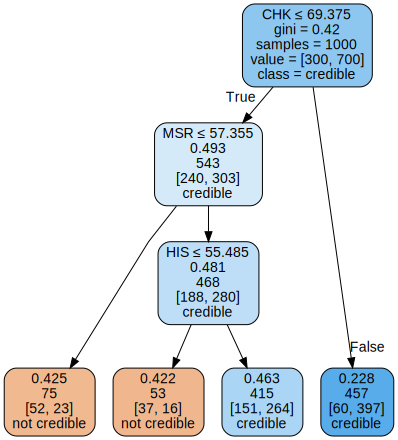

In [109]:
# class_weight equal but MID = 0.01
name = 'DT_testing_MID_1_'
clf = DecisionTreeClassifier(min_impurity_decrease = 0.01).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

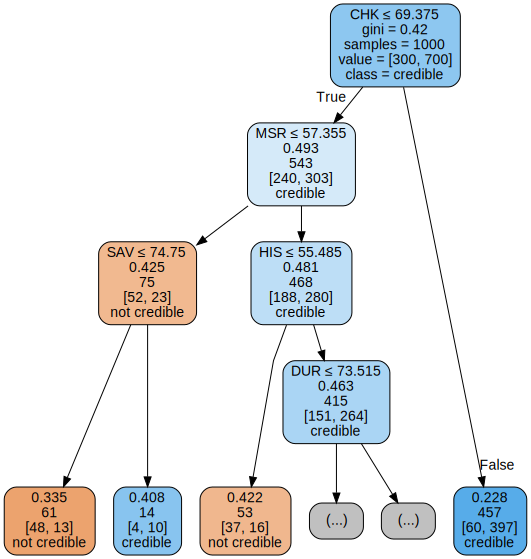

In [96]:
# class_weight equal but MID = 0.005
name = 'DT_testing_MID_05_'
clf = DecisionTreeClassifier(min_impurity_decrease = 0.005).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

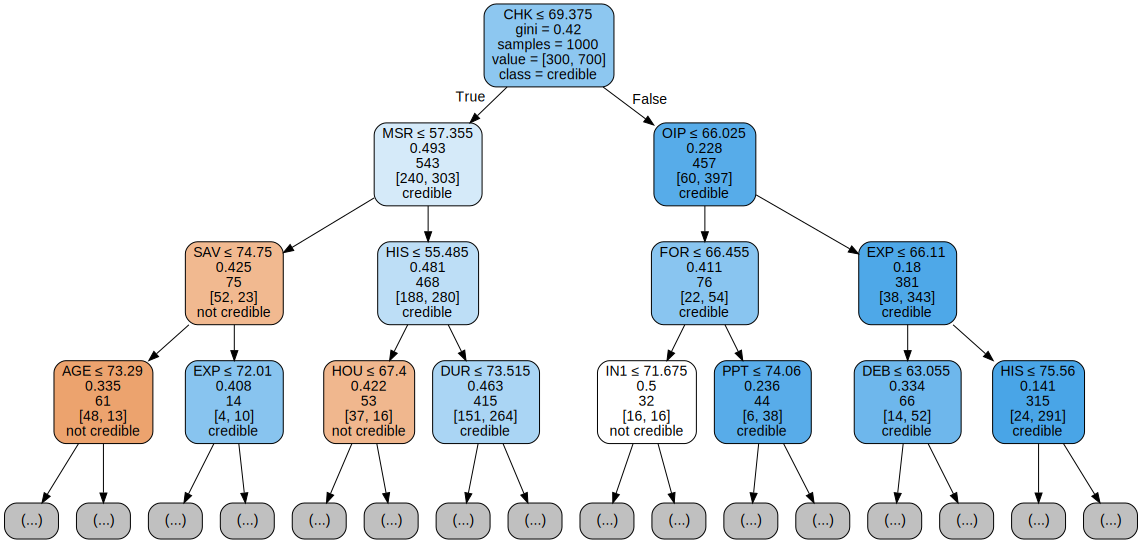

In [74]:
# class_weight equal (default setting)
name = 'DT_testing_default_'
clf = DecisionTreeClassifier().fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

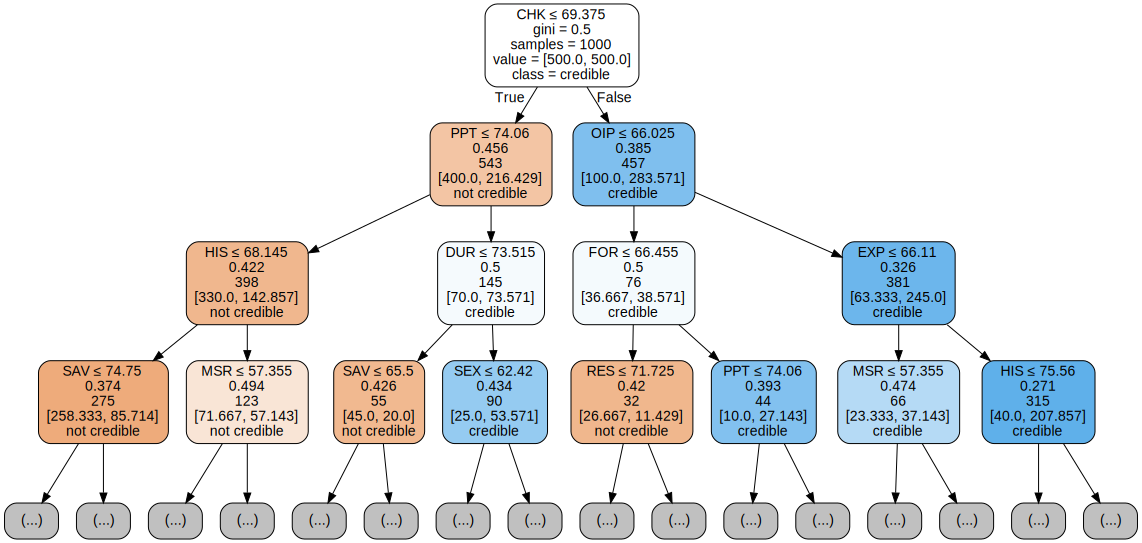

In [75]:
# class_weight = 'balanced'
name = 'DT_testing_balanced_'
clf = DecisionTreeClassifier(class_weight='balanced').fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

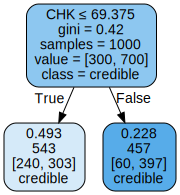

In [80]:
# class_weight equal but MSL = 0.4
name = 'DT_testing_MSL_40_'
clf = DecisionTreeClassifier(min_samples_leaf = 0.4).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

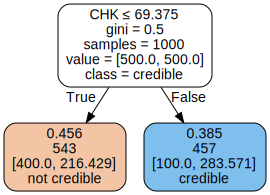

In [81]:
# class_weight balanced but MSL = 0.4
name = 'DT_testing_balanced_MSL_40_'
clf = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf = 0.4).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

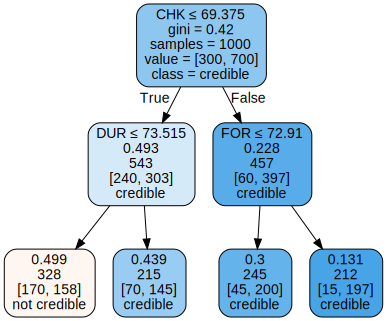

In [82]:
# class_weight equal but MSL = 0.2
name = 'DT_testing_MSL_20_'
clf = DecisionTreeClassifier(min_samples_leaf = 0.2).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

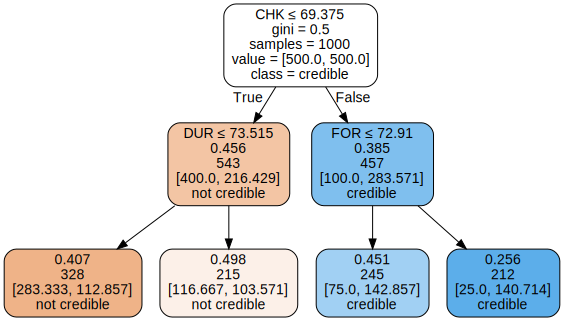

In [83]:
# class_weight 'balanced' but MSL = 0.2
name = 'DT_testing_balanced_MSL_20_'
clf = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf = 0.2).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

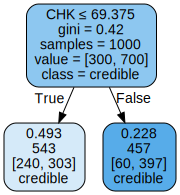

In [70]:
# class_weight equal but MWFL = 0.4
name = 'DT_testing_MWFL_40_'
clf = DecisionTreeClassifier(min_weight_fraction_leaf = 0.4).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

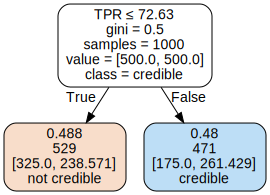

In [71]:
# class_weight balanced but MWFL = 0.4
name = 'DT_testing_balanced_MWFL_40_'
clf = DecisionTreeClassifier(class_weight='balanced', min_weight_fraction_leaf = 0.4).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

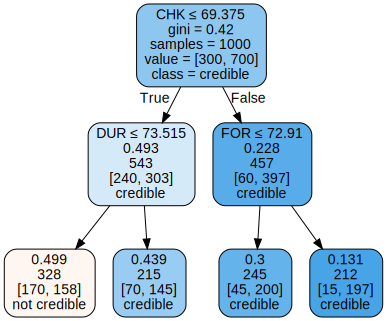

In [72]:
# class_weight equal but MWFL = 0.2
name = 'DT_testing_MWFL_20_'
clf = DecisionTreeClassifier(min_weight_fraction_leaf = 0.2).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

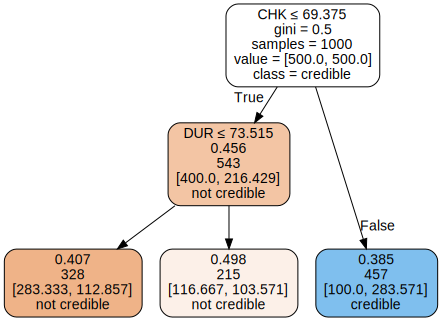

In [73]:
# class_weight 'balanced' but MWFL = 0.2
name = 'DT_testing_balanced_MWFL_20_'
clf = DecisionTreeClassifier(class_weight='balanced', min_weight_fraction_leaf = 0.2).fit(fe_cne.values, y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,
                                class_names= {0:'not credible', 1:'credible'}, filled=True, 
                                rounded=True, max_depth=3, label='root', leaves_parallel=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'svg'
graph.render(name, cleanup=True)
SVG('{}.svg'.format(name))

# In Progress

In [ ]:
# [DEPRECIATED] Old Summary
kwargs = {'ymax':0.38, 'ydiv':0.03, 'rot':0}
print 'Correlations of features in CON format:'
data = pd.concat([raw['amount'], raw['inst_rate'], fe_con], axis=1)
PLOT_CORR(data, **kwargs)
print 'Correlations of features in CNE format:'
data = pd.concat([fe_cne], axis=1)
PLOT_CORR(data, **kwargs)
print 'Correlations of features in OHE format:'
kwargs = {'ymax':0.38, 'ydiv':0.03, 'rot':90}
data = pd.concat([fe_ohe], axis=1)
PLOT_CORR(data, **kwargs)
print 'Number of OHE categories:',len(fe_ohe.columns)
print '\n', entropy.T

def PLOT_CORR(data, **kwargs):
    corr = [np.corrcoef(data[col].values, raw['default'].values)[0, 1] for col in data.columns]
    corr_test = pd.DataFrame(data=corr, index=[col for col in data.columns], columns=['default'])
    
    bins = range(0, len(corr))
    colors = ['r' if i > 0 else 'w' for i in corr]
    data = [i if i > 0 else i*-1 for i in corr]
    
    plt.bar(bins, data, color=colors, alpha=0.8)
    
    plt.xticks(bins, corr_test.index, rotation=kwargs['rot'])
    plt.xlim([-0.5, len(corr)-0.5])
    plt.yticks(np.arange(0, kwargs['ymax'], kwargs['ydiv']))
    plt.ylabel('Correlation Coefficient')
    plt.grid(True, alpha=0.15)
    #plt.tight_layout()
    
    plt.show()

In [121]:
# [IN PROGRESS] New Summary

# correlations calculated in pervious cells

for i,f in enumerate(feature_names):
    
    #fig = plt.figure()
    
    if i < 5:
        
        data = [con_corr[f], cne_corr[f]]
        labels = ['Continuous','CN Encoding']
        for index in ohe_corr.index.values.tolist():
            if index[0:3] == f:
                data.append(ohe_corr[index])
                labels.append(index[4:])
        #print pd.Series(data=data, index=labels,name=f)
        
    else:
        data = [cne_corr[f]]
        labels = ['CN Encoding']
        for index in ohe_corr.index.values.tolist():
            if index[0:3] == f:
                data.append(ohe_corr[index])
                labels.append(index[4:])
        #print pd.Series(data=data, index=labels,name=f)

print probs

   Feature     Category    Ratio     P(C)  Bad Good   P(C|B)   P(C|G)    lk_BC    lk_GC     H(C)   H(C,B)   H(C,G)   I(C,B)   I(C,G)
0      MSR       [0-18)     7.19    24.70   59  188    19.67    26.86    23.89    76.11     0.50     0.24     0.45    -0.02     0.02
1      MSR      [18-36)     5.14    21.60   54  162    18.00    23.14    25.00    75.00     0.48     0.23     0.43    -0.01     0.02
2      MSR      [36-78)     2.38    22.00   61  159    20.33    22.71    27.73    72.27     0.48     0.25     0.42    -0.01     0.01
3      MSR     [78-222)    -1.76    20.10   64  137    21.33    19.57    31.84    68.16     0.47     0.25     0.39     0.01    -0.01
4      MSR    [222-inf)   -12.95    11.60   62   54    20.67     7.71    53.45    46.55     0.36     0.25     0.23     0.05    -0.03
5      TPR   [400-1000)    10.24    26.50   58  207    19.33    29.57    21.89    78.11     0.51     0.24     0.47    -0.03     0.03
6      TPR      [0-400)     7.05    20.60   47  159    15.67    22.71

In [27]:
# [IN PROGRESS] Implementing RFE (in progress)

fe_mode = ['Continous', 'Custom Nucmericanl Encoded', 'One Hot Encoded']

fe_features = [fe_con, fe_cne, fe_ohe]


for i, feature in enumerate(fe_features):
    print 'FE Mode:', fe_mode[i]
    
    tree = DecisionTreeClassifier()
    hps = BSCV(model, params[count], n_jobs=8, cv=8, scoring='roc_auc',
                           return_train_score=False, iid=False,
                           n_iter=kwargs['iters'][count],
                           random_state=kwargs['state'])
    res = pd.DataFrame()
    
    
for i, model in enumerate(models):
    selector = RFE(model, 1)
    selector = selector.fit(fe_cne, y)
    data = pd.Series(data=selector.ranking_, index=feature_names)
    data = data.sort_values()
    data = pd.Series(data=data.index.values, name=model_names[i])
    res = pd.concat([res, data], axis=1)
    #res = pd.concat([res, data])
    #print res.sort_values(axis=0, by=0).T
display (res.T)    

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

FE Mode: Continous


NameError: name 'model' is not defined

In [43]:
# [IN PROGRESS] Core Code

# Models and their 'base' settings
RFC = RandomForestClassifier(max_features='sqrt', bootstrap=False)
GBC = GradientBoostingClassifier(max_features=None)
ADA = AdaBoostClassifier()
BGC = BaggingClassifier()
LRC = LogisticRegression(solver='liblinear', max_iter=1000)
VEC = LinearSVC(dual=False)
models = [RFC,GBC,ADA,BGC,LRC,VEC]
model_names = ['RFC','GBC','ADA','BGC','LRC','VEC']

def PLOT_DT_MAX_DEPTH(max_dep, fea_names, X_train, y_train, X_test, y_test):
    """
    Plots feature importances and accuracy score of a gini and enptropy decision tree clf across
    a range of depths
    """
    fig = plt.figure(figsize=[25, 5])
    ax2 = fig.add_subplot(131); plt.title("Gini")
    ax3 = fig.add_subplot(132); plt.title("Entropy")
    ax1 = fig.add_subplot(133); plt.ylabel("Accuracy")
    plt.yticks(np.arange(0.66, 0.80, 0.004))
    plt.xticks(np.arange(1, max_dep, 1))
    
    for criteria in ('gini', 'entropy'):
        
        test_accuracy = []
        imps = []
        
        for depth in range(1, max_dep):
            
            tree = DecisionTreeClassifier(max_depth=depth, criterion=criteria, random_state=2017)
            tree.fit(X_train, y_train)
            test_accuracy.append(tree.score(X_test, y_test))
            
            fea = tree.feature_importances_.tolist()
            max0, min0 = max(fea), min(fea)
            fea = list(map((lambda x: (x-min0)/(max0-min0)),fea))
            imps.append(fea)
            
        fea_imp = pd.DataFrame(data=imps, columns=fea_names, index=range(1, max_dep))
        sns.heatmap(fea_imp.T, annot=False, fmt=".2f", square=True, cmap='binary', cbar=False,
                    annot_kws={"size": 8}, ax=ax2 if criteria == 'gini' else ax3)
        ax1.plot(range(1, max_dep), test_accuracy, '--.', label=criteria)
        
    ax1.grid(True)
    ax1.legend(loc='best')
    return plt.show()

def HPS(pars, models, model_names, X_train, y_train, do, heads, split_drop=1, **kwargs):
    """
    Conducts an exhaustive grid search if **kwargs is empty otherwise uses 
    skopt.BayesSearchCV
    
     --------
    | OUTPUT | tuned_models, best_params, search_results
     --------
    
    split_drop    if not set to 1 will not hide split_test_score of cv_results_
    
    heads         if higher than 0 will print that many sorted heads of search_results 
    """
    tuned_models = []
    best_params = []
    search_results = []
    
    for count,model in enumerate(models):
        
        # In case one wants to run only a selection of the models
        if count in do:
            
            winsound.Beep(1800,150) # To let one know it started a model
            
            if kwargs == {}:
                
                #print '>>> Starting exhaustive grid search'
                hps = GSCV(model, params[count], n_jobs=8, cv=8, scoring='roc_auc', 
                           return_train_score=False, iid=False)
                
            else:
                
                #print '>>> Starting Bayesian search'
                hps = BSCV(model, params[count], n_jobs=8, cv=8, scoring='roc_auc',
                           return_train_score=False, iid=False,
                           n_iter=kwargs['iters'][count],
                           random_state=kwargs['state'])
                
            hps.fit(X_train, y_train)
            print("{} {:.4f} {}".format(model_names[count], hps.best_score_, hps.best_params_))
            
            # Saving cv_results_
            res = pd.DataFrame(hps.cv_results_).sort_values(by=['mean_test_score'], axis=0,
                                                            ascending=False)
            res.reset_index(inplace=True, drop=True)
            a = res[['mean_test_score', 'std_test_score']]
            res.drop(['mean_test_score', 'std_test_score', 'params',
                      'mean_fit_time',
                      'mean_score_time',
                      'std_fit_time',
                      'std_score_time'], axis=1, inplace=True)
            if split_drop == 1: res.drop(['split{}_test_score'.format(i) for i in range(0,8)],
                                         axis=1, inplace=True)
            res = pd.concat([a, res], axis=1)
            if heads>0: display(res.head(heads).T)
                
            tuned_models.append(hps.best_estimator_)
            best_params.append(hps.best_params_)
            search_results.append(res)
            
            winsound.Beep(1500,250) # To let one know it finished a model
    winsound.Beep(2000,500) # To let one know its completely done
    return tuned_models, best_params, search_results

def GENERATE_VOTING_COMBOS(votable_models, models, X_train, y_train, names):
    """
    Generates and fits soft and hard voting ensemble combinations
    """
    all_models = []
    all_names = []
    
    for count in range(2, len(votable_models)+1):
        
        # Generating combinations
        combos = [combo for combo in combinations(votable_models, count)]
        
        for combo in combos:
            
            # Generating soft voting models
            voter = EnsembleVoteClassifier(clfs=[models[i] for i in combo], voting='soft',
                                           refit=False).fit(X_train, y_train)
            name = 'soft('+', '.join([names[letter] for letter in combo])+')'
            all_models.append(voter)
            all_names.append(name)
            
            if count % 2 == 1:
                
                # Generating hard voting models only if number of models is odd
                voter = EnsembleVoteClassifier(clfs=[models[i] for i in combo], voting='hard', 
                                               refit=False).fit(X_train, y_train)
                name = 'hard('+', '.join([names[letter] for letter in combo])+')'
                all_models.append(voter)
                all_names.append(name)
                
    return all_models, all_names

def FIND_OPTIMAL_THRESHOLD_AND_TEST(models, model_names, X_train, y_train, X_test, y_test, expt):
    """
    Finds optimal ROC thresholds, tests all models (both non-optimized and optimized) and generates
    3 reports:
    
    1. Accuracy and error type report (also stores optimal thresholds)
    2. Non-optimized models' predictions
    3. Optimized models' predictions
    
     --------
    | OUTPUT | AETR, nm_preds, om_preds
     --------
     
    expt   index of model(s) without predict_proba_ method
    """
    reports = []
    nm_preds = pd.DataFrame(data=y_test,columns=['Actual'])
    om_preds = pd.DataFrame(data=y_test,columns=['Actual'])
    
    for count, model in enumerate(models):
        winsound.Beep(3000,100) # To let one know it started a model
        
        # Generating non-optimized model predictions (testing)
        y_pred_test = model.predict(X_test).tolist()
        new_preds = pd.DataFrame(data=y_pred_test, columns=[model_names[count]])
        nm_preds = pd.concat([nm_preds, new_preds], axis=1)
        
        # (Finding optimal ROC Threshold)
        if count not in expt:
            
            # If model has predict_proba_ method
            y_pred_prob = model.predict_proba(X_train)[:, 1]
            y_pred_prob_test = model.predict_proba(X_test)[:, 1]
            
        else:
            
            # If not then use decision_function
            y_pred_prob = model.decision_function(X_train)
            y_pred_prob_test = model.decision_function(X_test)
        
        # Finding optimal ROC threshold
        fpr, tpr, threshold = metrics.roc_curve(y_train, y_pred_prob)
        roc = pd.DataFrame({'tf':pd.Series(tpr-(1-fpr), index=np.arange(len(tpr))),
                            'threshold':pd.Series(threshold, index=np.arange(len(tpr)))})
        roc_t = roc.iloc[(roc['tf']-0).abs().argsort()[:1]]
        optimal_threshold = list(roc_t['threshold'])
        
        # Generating optimzed predictions (testing)
        y_pred_optimal_test = np.where(y_pred_prob_test >= optimal_threshold, 1, 0)
        new_preds = pd.DataFrame(data=y_pred_optimal_test, columns=[model_names[count]])
        om_preds = pd.concat([om_preds, new_preds],axis=1)
        
        # Generating confusion matric (error types)
        ncm = metrics.confusion_matrix(y_test, y_pred_test)
        ocm = metrics.confusion_matrix(y_test, y_pred_optimal_test)
        
        # Generating non-optimized and optimized model accuracy and error type report
        report = [model_names[count], optimal_threshold[0],
                  metrics.accuracy_score(y_test, y_pred_optimal_test)*100, ocm[0,1], ocm[1,0],
                  metrics.accuracy_score(y_test, y_pred_test)*100, ncm[0,1], ncm[1,0]]
        reports.append(report)
    
    AETR = pd.DataFrame(data=reports,
                        columns=['Model', 'threshold', 'oACC', 'o2', 'o1', 'nACC', 'n2', 'n1'])
    
    winsound.Beep(1500,75) # To let one know it finished all models
    return AETR, nm_preds, om_preds

def PLOT_FEATURE_IMPORTANCES(fea_names, models, model_names, do=(0,1,2), xlim=0.27):
    """
    Plots feature importances for RFC, GBC and ADA
    """
    n_features = len(fea_names)
    n_models = len(do)
    fig = plt.figure(figsize=[5*n_models, 15])
    
    for i in range(1, n_models+1):
        
        ax = fig.add_subplot(n_models, 1, i)
        plt.yticks(range(n_features), fea_names)
        plt.title(model_names[do[i-1]])
        plt.xlim((0, xlim))
        plt.xticks(np.arange(0, xlim, 0.02))
        ax.barh(range(n_features), models[do[i-1]].feature_importances_, align='center')
        ax.grid(True)
    
    return plt.show()

def PLOT_AETR(model_names, report, t1e=(6.5, 22.5, 0.5), t2e=(5, 18.5, 0.5), acc=(70.5, 80, 0.5)):
    """
    Plots Type 1 Error, Type 2 Error and Accuracy or all models (non-optimized and optimized)
    """
    
    titles = ('Non Type 1 Error',
              'Non Type 2 Error',
              'Opt Type 1 Error',
              'Opt Type 1 Error',
              'Non Test Accuracy',
              'Opt Test Accuracy')
    
    subs = (325, 323, 326, 324, 321, 322)
    col = ('n1', 'n2', 'o1', 'o2', 'nACC', 'oACC')
    colors = ('r','g','r','g','b','b')
    orders = (0,2,1,3,4,5)
    
    n_models = len(final_model_names)
    fig = plt.figure(figsize=[30,50])
    
    for i in (0,1,2,3,4,5):
        
        ax_n = fig.add_subplot(subs[i])
        plt.title(titles[i])
        plt.yticks(range(n_models), report['Model'])
        
        if i in (0,2):
            plt.xticks(np.arange(t1e[0], t1e[1], t1e[2]))
            plt.xlim((t1e[0], t1e[1]))
            
        elif i in (1,3):
            plt.xticks(np.arange(t2e[0], t2e[1], t2e[2]))
            plt.xlim((t2e[0], t2e[1]))
            
        else:
            plt.xticks(np.arange(acc[0], acc[1], acc[2]))
            plt.xlim((acc[0], acc[1]))
            
        ax_n.barh(range(n_models), report[col[i]], align='center',color=colors[i])
        ax_n.grid(True)
        
    return plt.show()

def main(X, y, fea_names, pars, models, model_names, do=range(0,6), heads=0, show=False, **kwargs):
    """
    Splits the data, conducts grid or bayesian search and 
    then optimizes models if hyper parameter tuning is over
    """
    # Creating train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2017)
    
    # Hyperparameter search
    if kwargs == {}:
        # Grid search
        tuned_models, best_par, res = HPS(pars, models, model_names, X_train, y_train, do, heads)
    else:
        # Bayesian search
        tuned_models, best_par, res = HPS(pars, models, model_names, X_train, y_train, do, heads,
                                          iters=kwargs['iters'], state=kwargs['state'])
    
    if heads == 0:
        # Creating all possible hard and soft voting ensemble combinations
        votable_models = [0,1,2,3,4] # Linear Support Vector Classifier does have predict_proba_
        en_voting_models, en_voting_names = GENERATE_VOTING_COMBOS(votable_models, tuned_models, 
                                                                   X_train, y_train,
                                                                   ['R','G','A','B','L'])
        all_models = tuned_models + en_voting_models
        all_names = model_names + en_voting_names
        
        # Threshold optimization and testing
        AETR, nm_preds, om_preds = FIND_OPTIMAL_THRESHOLD_AND_TEST(all_models, all_names, 
                                                                   X_train, y_train,
                                                                   X_test, y_test, [5])
        
        # Converting columns in AETR to percentages
        report = AETR.copy()
        report[['o2','o1','n2','n1']] = report[['o2','o1','n2','n1']].apply(lambda x:x*0.4)

        if show:
            # Stand alone decision tree performance with varying max_depths and criterias
            PLOT_DT_MAX_DEPTH(22, fea_names, X_train, y_train, X_test, y_test)
            
            # Feature impotances of doable models
            PLOT_FEATURE_IMPORTANCES(fea_names, all_models)

            # Comparing performance of all models
            PLOT_AETR(all_names, report)
            
        print(report.sort_values(['nACC'], ascending=False))
        winsound.Beep(70,1000); winsound.Beep(2900,600)
        winsound.Beep(1000,250); winsound.Beep(500,400)
        return [tuned_models, best_par, res, AETR, nm_preds, om_preds, report]
    else:
        winsound.Beep(70,1000); winsound.Beep(2900,600)
        winsound.Beep(1000,250); winsound.Beep(500,400)
        return [tuned_models, best_par, res]

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

## Feature Reduction Attempt

          Category
0  SEX:male_single
1       SEX:female
2      SEX:male_ds
3      SEX:male_mw
0        AGE[0-26)
1       AGE[26-30)
2       AGE[30-35)
3       AGE[35-41)
4       AGE[41-52)
5      AGE[52-inf)


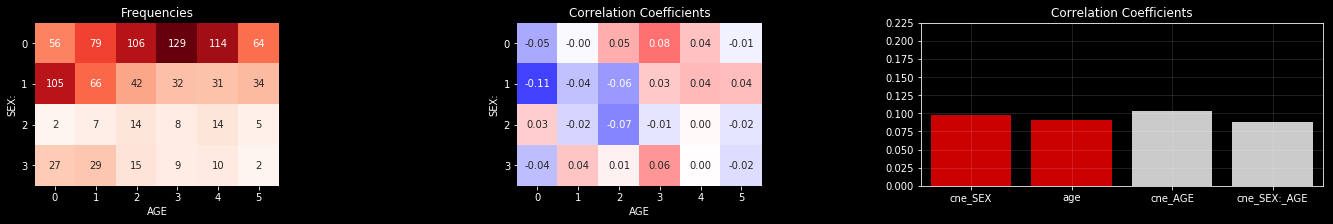

  Category
0    FRN:1
1    FRN:2
0    RES:1
1    RES:3
2    RES:2
3    RES:4


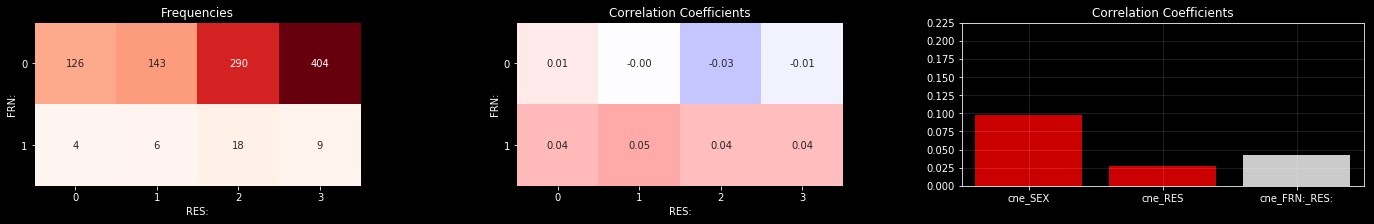

                        Category
0  JOB:unemp / unskill (non-res)
1       JOB:unskilled (resident)
2         JOB:skilled / official
3         JOB:man/self-em/HQ/off
0                 EXP:unemployed
1                EXP:less than 1
2           EXP:1 to less than 4
3           EXP:4 to less than 7
4                EXP:more than 7


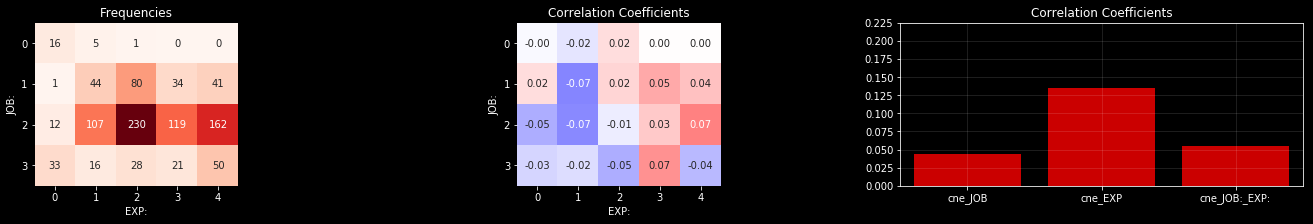

  Category
0    PPL:1
1    PPL:2
0    TEL:1
1    TEL:2


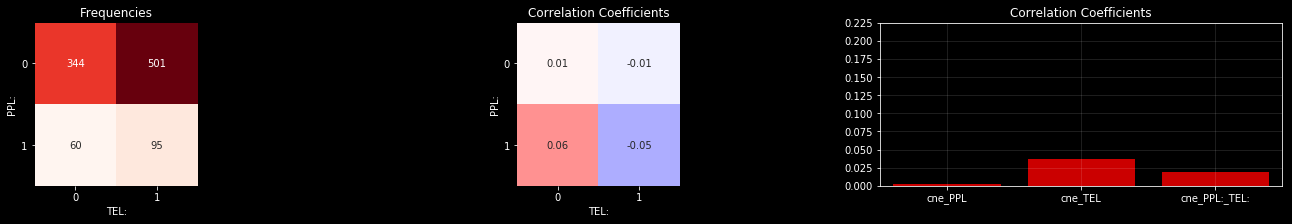

          Category
0         OIP:none
1         OIP:bank
2       OIP:stores
0      SAV:unk_nil
1         SAV:<100
2   SAV:101 to 500
3  SAV:501 to 1000
4        SAV:>1000


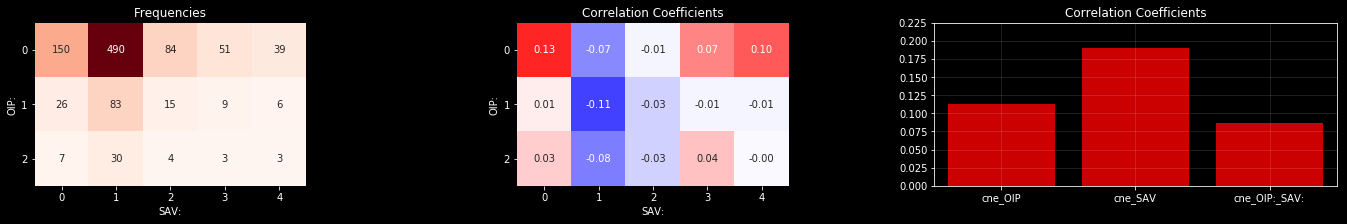

          Category
0         HOU:free
1         HOU:rent
2          HOU:own
0     PPT:UNK/None
1    PPT:Car/Other
2    PPT:BSSA/Life
3  PPT:real estate


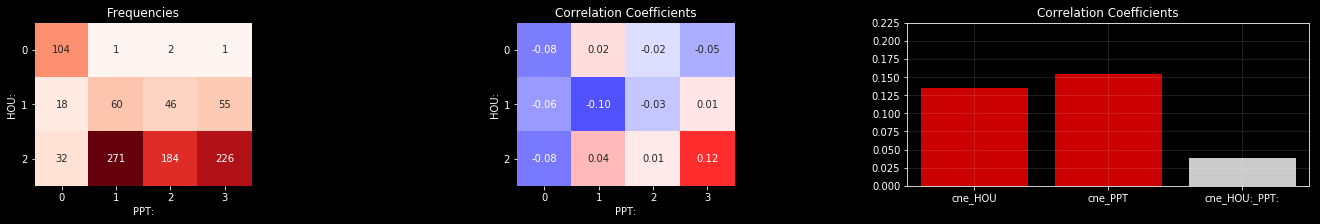

       Category
0     MSR[0-18)
1    MSR[18-36)
2    MSR[36-78)
3   MSR[78-222)
4  MSR[222-inf)
0   FOR:rad_tel
1       FOR:edu
2   FOR:fur_equ
3   FOR:car_new
4  FOR:car_used
5  FOR:business
6   FOR:dom_app
7   FOR:repairs
8    FOR:retain


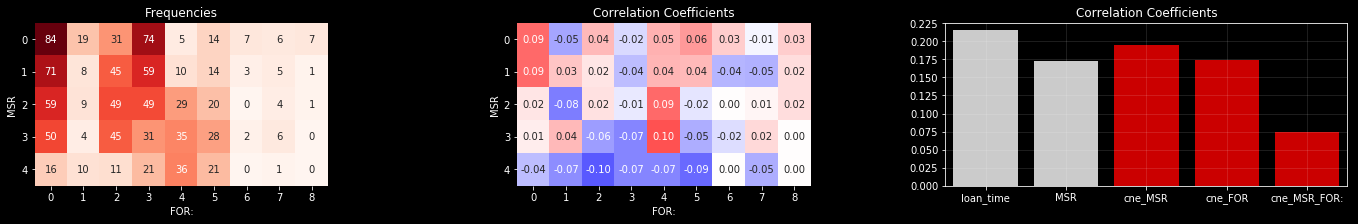

         Category
0      TPR[0-400)
1   TPR[400-1000)
2  TPR[1000-2200)
3  TPR[2200-5800)
4   TPR[5800-inf)
0     FOR:rad_tel
1         FOR:edu
2     FOR:fur_equ
3     FOR:car_new
4    FOR:car_used
5    FOR:business
6     FOR:dom_app
7     FOR:repairs
8      FOR:retain


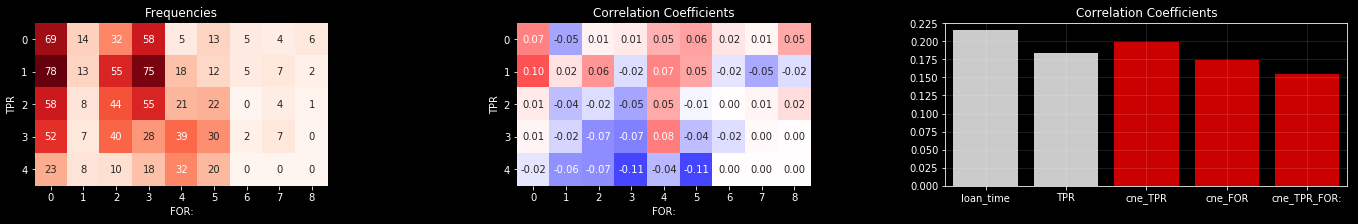

In [1002]:
# Feature reduction
def FEATURE_REDUCTION(N1, N2, C1, C2, kwargs, compare, O1, O2, show=True):
    '''
    Takes two categorical series and reduces them into 1 and plots
    performance if show is True
    '''
    # Creating new feature
    U1 = ['{}{}'.format(N1, category) for category in C1.unique()]
    U2 = ['{}{}'.format(N2, category) for category in C2.unique()]
    new_feature = ['{}{} {}{}'.format(N1, C1[i], N2, C2[i]) for i in range(0, 1000)]
    new_feature = pd.Series(new_feature)
    new_name = '{}_{}'.format(N1, N2)
    new_feature.name = new_name
    counts = new_feature.value_counts()
    
    if show:
        
        # Generating new category names, frequencies and correlations with default
        U1 = [U1[i] for i in O1]; a = pd.DataFrame(data=U1, columns=['Category'])
        U2 = [U2[i] for i in O2]; b = pd.DataFrame(data=U2, columns=['Category'])
        print(pd.concat([a,b], axis=0))
        freq = np.zeros((len(U1), len(U2)), dtype=np.int64)
        corr = np.zeros((len(U1), len(U2)))
        labels = []
        for x, A in enumerate(U1):
            for y, B in enumerate(U2):
                label = '{} {}'.format(A, B)
                if label in counts.index:
                    labels.append(label)
                    freq[x,y] = counts[label]
                    data = [1 if i==label else 0 for i in new_feature.values]
                    corr[x,y] = np.corrcoef(data, raw['default'].values)[0,1]
        freq_dist = pd.DataFrame(data=freq, columns=U2, index=U1)
        corr_dist = pd.DataFrame(data=corr, columns=U2, index=U1)
        data = pd.concat([new_feature, raw['default']], axis=1)
        res = CALCULATE_POSTERIOR_PROB(data, new_name)
        #print(res)
        dict_ = dict(zip(labels, res['lk_GC'].values))
        cne_feature = new_feature.map(dict_)
        cne_feature.name = 'cne_{}'.format(new_name)
        ohe_feature = pd.get_dummies(new_feature)
        ohe_feature = ohe_feature[[label for label in labels]]
        
        fig = plt.figure(figsize=[24.5, 3])
        
        # Plotting heatmap illustrating frequency distribution of new categories
        ax1 = fig.add_subplot(131)
        plt.title('Frequencies')
        sns.heatmap(data=freq_dist, annot=True, cbar=False, ax=ax1, square=True, fmt='d', cmap='Reds')
        plt.ylabel(N1); plt.xlabel(N2)
        plt.yticks(np.arange(0.5,len(U1)+0.5, 1), range(0,len(U1)), rotation=0)
        plt.xticks(np.arange(0.5,len(U2)+0.5, 1), range(0,len(U2)), rotation=0)
        
        ax2 = fig.add_subplot(132)
        plt.title('Correlation Coefficients')
        sns.heatmap(data=corr_dist, annot=True, cbar=False, ax=ax2, square=True, fmt='.2f', cmap='seismic', center=0.0, vmax=0.3, vmin=-0.3)
        plt.ylabel(N1); plt.xlabel(N2)
        plt.yticks(np.arange(0.5,len(U1)+0.5, 1), range(0,len(U1)), rotation=0)
        plt.xticks(np.arange(0.5,len(U2)+0.5, 1), range(0,len(U2)), rotation=0)
        
        #Plotting bar chart to assess performance by comparing correlations
        data = pd.concat([compare, cne_feature], axis=1)
        corr = [np.corrcoef(data[col].values, raw['default'].values)[0, 1] for col in data.columns]
        corr_test = pd.DataFrame(data=corr, index=[col for col in data.columns], columns=['default'])
        bins = range(0, len(corr))
        colors = ['r' if i > 0 else 'w' for i in corr]
        data = [i if i > 0 else i*-1 for i in corr]
        
        ax3 = fig.add_subplot(133)
        plt.bar(bins, data, color=colors, alpha=0.8)
        args = ['rot', 'ymax', 'ydiv']
        default_settings = [0, 0.5, 0.025]
        for i, arg in enumerate(args):
            if arg not in kwargs: kwargs[arg] = default_settings[i]
        plt.xticks(bins, corr_test.index, rotation=kwargs['rot'])
        plt.xlim([-0.5, len(corr)-0.5])
        plt.yticks(np.arange(0, kwargs['ymax'], kwargs['ydiv']))
        plt.title('Correlation Coefficients')
        plt.grid(True, alpha=0.15)
        
        plt.show()
        return [new_feature, cne_feature, ohe_feature, res]
    else:
        print U1
        print U2

# Feature reduction pairs:
kwargs = {'rot': 0, 'ymax':0.25}

# 1. SEX AGE
o_sex = range(0,4) # order does not matter
o_age = [1,4,5,3,2,0]
compare = pd.concat([cne_ordinals['cne_SEX'], raw['age'], cne_numericals['cne_AGE']], axis=1)
PER1 = FEATURE_REDUCTION('SEX:', 'AGE', raw['sex'], bin_numericals['bin_AGE'], kwargs, compare, o_sex, o_age, show=True)

# 2. FRN RES
o_frn = range(0,2) # order does not matter
o_res = [3,2,1,0]
compare = pd.concat([cne_ordinals['cne_SEX'], cne_ordinals['cne_RES']], axis=1)
PER2 = FEATURE_REDUCTION('FRN:', 'RES:', raw['foreign'], raw['residence'], kwargs, compare, o_frn, o_res, show=True)

# 3. EXP JOB
o_exp = [3,4,1,2,0]
o_job = [3,1,0,2]
compare = pd.concat([cne_ordinals['cne_JOB'], cne_ordinals['cne_EXP']], axis=1)
EMP0 = FEATURE_REDUCTION('JOB:', 'EXP:', raw['job'], raw['job_status'], kwargs, compare, o_job, o_exp, show=True)

# 4. PPL TEL
o_ppl = [0,1]
o_tel = [0,1]
compare = pd.concat([cne_ordinals['cne_PPL'], cne_ordinals['cne_TEL']], axis=1)
CON0 = FEATURE_REDUCTION('PPL:', 'TEL:', raw['people'], raw['telephone'], kwargs, compare, o_ppl, o_tel, show=True)

# 5. SAV OIP
o_sav = [0,1,4,2,3]
o_oip = [0,1,2]
compare = pd.concat([cne_ordinals['cne_OIP'], cne_ordinals['cne_SAV']], axis=1)
FIN1 = FEATURE_REDUCTION('OIP:', 'SAV:', raw['OIP'], raw['savings'], kwargs, compare, o_oip, o_sav, show=True)

# 6. PPT HOU
o_ppt = [2,3,1,0]
o_hou = [1,2,0]
compare = pd.concat([cne_ordinals['cne_HOU'], cne_ordinals['cne_PPT']], axis=1)
FIN2 = FEATURE_REDUCTION('HOU:', 'PPT:', raw['housing'], raw['property'], kwargs, compare, o_hou, o_ppt, show=True)

# 7. MSR FOR
o_msr = [0,2,4,3,1]
o_for = range(0,9)
compare = pd.concat([raw['loan_time'], onf_numericals['MSR'], cne_numericals['cne_MSR'], cne_ordinals['cne_FOR']], axis=1)
LON1 = FEATURE_REDUCTION('MSR', 'FOR:', bin_numericals['bin_MSR'], raw['for'], kwargs, compare, o_msr, o_for, show=True)

# 8. TPR FOR
o_tpr = [0,2,4,1,3]
compare = pd.concat([raw['loan_time'], onf_numericals['TPR'], cne_numericals['cne_TPR'], cne_ordinals['cne_FOR']], axis=1)
LON2 = FEATURE_REDUCTION('TPR', 'FOR:', bin_numericals['bin_TPR'], raw['for'], kwargs, compare, o_tpr, o_for, show=True)

# Remaining: DUR, IN1, DEP

                      Category
0   F2-HOU:own PPT:real estate
1    F2-HOU:free PPT:BSSA/Life
2     F2-HOU:free PPT:UNK/None
3     F2-HOU:own PPT:BSSA/Life
4    F2-HOU:rent PPT:Car/Other
5     F2-HOU:own PPT:Car/Other
6    F2-HOU:rent PPT:BSSA/Life
0      F1-OIP:none SAV:unk_nil
1         F1-OIP:none SAV:<100
2  F1-OIP:none SAV:501 to 1000
3        F1-OIP:none SAV:>1000
4   F1-OIP:none SAV:101 to 500
5      F1-OIP:bank SAV:unk_nil
6         F1-OIP:bank SAV:<100
7        F1-OIP:bank SAV:>1000


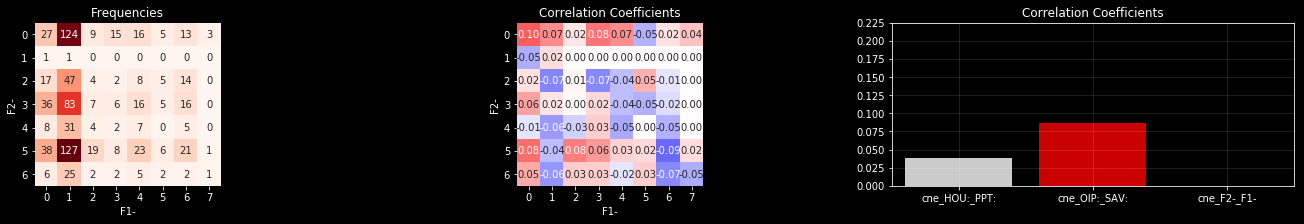

                         Category
0                  P2-FRN:1 RES:4
1                  P2-FRN:1 RES:2
2                  P2-FRN:1 RES:3
3                  P2-FRN:1 RES:1
4                  P2-FRN:2 RES:3
5                  P2-FRN:2 RES:1
0  P1-SEX:male_single AGE[52-inf)
1         P1-SEX:female AGE[0-26)
2   P1-SEX:male_single AGE[41-52)
3   P1-SEX:male_single AGE[35-41)
4      P1-SEX:male_ds AGE[52-inf)
5       P1-SEX:male_mw AGE[26-30)
6        P1-SEX:female AGE[26-30)
7        P1-SEX:female AGE[30-35)
8    P1-SEX:male_single AGE[0-26)
9        P1-SEX:female AGE[41-52)


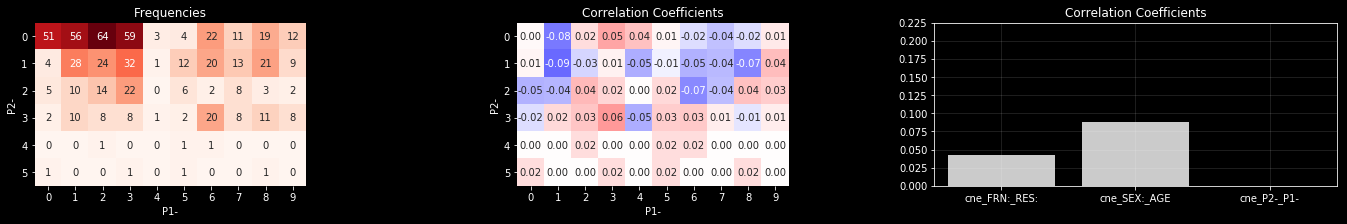

In [1004]:
# new_feature, cne_feature, ohe_feature, res
# FINANCIAL PROFILE
O1 = range(0,7)
O2 = range(0,8)
compare = pd.concat([FIN2[1], FIN1[1]], axis=1)
financial_profile = FEATURE_REDUCTION('F2-', 'F1-', FIN2[0], FIN1[0], kwargs, compare, O1, O2, show=True)
#print financial_profile[3]
# print

# Personal
O1 = range(0,6)
O2 = range(0,10)
compare = pd.concat([PER2[1], PER1[1]], axis=1)
personal = FEATURE_REDUCTION('P2-', 'P1-', PER2[0], PER1[0], kwargs, compare, O1, O2, show=True)

# Old Code

In [44]:
# D A T A S E T   1   A N D   2   ###   C O M M O N   P R E P S

# Numerical features
NU_fe = raw[['loan_time', 'age', 'amount']]

# Stating which features are being treated as ordinal features
categorical_features = ['n_credits', 'people', 'inst_rate', 'residence', 'job', 'checking', 
                        'history', 'savings', 'job_status', 'property', 'housing', 'for', 'sex', 
                        'debtor', 'OIP', 'telephone', 'foreign']

# Dictionary consisting custom encoding keys for each category based and result
# on ****line 90****
dicts = [{4:-3.3, 1:-1.6, 2:2.4, 3:8.6}, # n_credits
         {1:-0.1, # ...................... people     
          2:0.3}, 
         {4:-3.3, # ...................... inst_rate  
          3:1.4,
          2:3.2,
          1:5}, 
         {2:-1.5, # ...................... residence  
          4:0,
          3:1.1,
          1:2.3}, 
         {'man/self-em/HQ/off':-4.5, # ... job        
          'unemp / unskill (non-res)':-1.8,
          'skilled / official':0.5,
          'unskilled (resident)':2}, 
         {'< 0':-19.3, # ................. checking   
          '0 to 200':-9,
          '> 201':7.8,
          'none':18.3}, 
         {'fully repaid':-32.5, # ........ history    
          'fully repaid here':-27.1,
          'repaid':-1.8,
          'delayed':-1.8,
          'critical':12.9}, 
         {'<100':-6, # ................... savings    
          '101 to 500':-3,
          'unk_nil':12.5,
          '501 to 1000':12.5,
          '>1000':17.5}, 
         {'less than 1':-10.7, # ......... job_status 
          'unemployed':-7.1,
          '1 to less than 4':-0.68,
          'more than 7':4.7,
          '4 to less than 7':7.6}, 
         {'UNK/None':-13.5, # ............ property   
          'Car/Other':-0.65,
          'BSSA/Life':-0.65,
          'real estate':8.7}, 
         {'own':1, # ..................... housing    
          'free':-1,
          'rent':-1}, 
         {'edu':-14, # ................... for        
          'car_new':-8,
          'repairs':-6.4,
          'business':-5,
          'dom_app':-3.3,
          'fur_equ':-2,
          'rad_tel':7.8,
          'car_used':10.9,
          'retain':18.9}, 
         {'male_ds':-10, # ............... sex        
          'female':-5,
          'male_mw':2.8,
          'male_single':3.4}, 
         {'coapplicant':-1, # ............ debtor     
          'none':0,
          'guarantor':1}, 
         {'none':1, # .................... OIP        
          'bank':-1,
          'stores':-1}, 
         {2:-1, # ........................ telephone  
          1:1}, 
         {1:0, # ......................... foreign    
          2:1}] 

# Mapping encodings
OD_fe = pd.DataFrame(columns=categorical_features)
for n,col in enumerate(categorical_features): OD_fe[col]=raw[col].map(dicts[n])

# FEature Engineered data that is will be used in dataset 1 and 2
fee_data = pd.concat([NU_fe, OD_fe], axis=1)

#Correlation matrix of fee_data
if False:
    data = pd.concat([fee_data, pd.DataFrame(data=y,columns=['Default'])], axis=1)
    fig = plt.figure(figsize=[20,15])
    ax1 = fig.add_subplot(111)
    sns.heatmap(data.corr(), annot=True, fmt=".2f", square=True, cmap='seismic', ax=ax1, 
                cbar=True,annot_kws={"size": 11}, vmin=-1, vmax=1)
    plt.show()

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

In [59]:
# D A T A S E T   2   ###   6   F E A T U R E S   R E M O V E D   ########### Bayes

# Eliminating features for dataset 2
dataset_2 = fee_data.copy()
drop_me = ['telephone','n_credits','people','inst_rate','residence','job']
dataset_2.drop(drop_me, axis=1, inplace=True)
X = dataset_2.values
feature_names = dataset_2.columns.values

# Grid search parameters
par_rfc = {'n_estimators':Integer(14, 170), 
           'criterion':Categorical(['gini','entropy']), 
           'max_depth':Integer(1, 14), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_gbc = {'n_estimators':Integer(14, 170), 
           'learning_rate':Real(1e-6, 1e+0, prior='log-uniform'), 
           'max_depth':Integer(1, 14), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_ada = {'n_estimators':Integer(14, 170), 
           'learning_rate':Real(1e-6, 1e+0, prior='log-uniform'), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_bgc = {'n_estimators':Integer(14, 170), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_lrc = {'penalty':Categorical(['l1', 'l2']), 
           'class_weight':Categorical([None, 'balanced']), 
           'fit_intercept':Categorical([False, True]), 
           'C':Real(1e-6, 1e+5, prior='log-uniform')}

par_vec = {'penalty':Categorical(['l1', 'l2']), 
           'class_weight':Categorical([None, 'balanced']), 
           'fit_intercept':Categorical([False, True]), 
           'C':Real(1e-6, 1e+5, prior='log-uniform')}

params = (par_rfc, par_gbc, par_ada, par_bgc, par_lrc, par_vec); i=100; iters=[i,i,i,i,i,i]

# main function
pd.options.display.float_format = '{:.4f}'.format
df2b = main(X, y, feature_names, params, models, model_names, heads=0, iters=iters, state=2017)

RFC 0.7896 {'n_estimators': 170, 'random_state': 2018, 'criterion': 'gini', 'max_depth': 8}
GBC 0.7953 {'n_estimators': 170, 'learning_rate': 0.07548790421314186, 'random_state': 46, 'max_depth': 3}
ADA 0.7799 {'n_estimators': 169, 'learning_rate': 0.06787263340955452, 'random_state': 2017}
BGC 0.7729 {'n_estimators': 170, 'random_state': 46}
LRC 0.8013 {'penalty': 'l2', 'C': 1663.205132514481, 'fit_intercept': False, 'class_weight': 'balanced'}
VEC 0.8012 {'penalty': 'l2', 'C': 0.30852340163365594, 'fit_intercept': True, 'class_weight': None}
                  Model  threshold    oACC      o2      o1    nACC      n2      n1
1                   GBC     0.6702 74.8000  9.2000 16.0000 80.4000 12.0000  7.6000
28        soft(G, A, B)     0.5641 77.2000 10.0000 12.8000 80.0000 11.6000  8.4000
10           soft(G, A)     0.5980 74.0000  8.8000 17.2000 80.0000 12.4000  7.6000
11           soft(G, B)     0.6103 76.0000  9.6000 14.4000 80.0000 11.6000  8.4000
33        hard(G, B, L)     0.5748 

In [104]:
# D A T A S E T   1   ###   A L L   F E A T U R E S   I N C L U D E D   ##### Bayes

# creating dataset 1
X = fee_data.values
feature_names = fee_data.columns.values

# Grid search parameters
par_rfc = {'n_estimators':Integer(14, 170), 
           'criterion':Categorical(['gini','entropy']), 
           'max_depth':Integer(1, 14), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_gbc = {'n_estimators':Integer(14, 170), 
           'learning_rate':Real(1e-6, 1e+0, prior='log-uniform'), 
           'max_depth':Integer(1, 14), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_ada = {'n_estimators':Integer(14, 170), 
           'learning_rate':Real(1e-6, 1e+0, prior='log-uniform'), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_bgc = {'n_estimators':Integer(14, 170), 
           'random_state':Categorical([5482, 46, 77, 2017, 2018, 25, 4])}

par_lrc = {'penalty':Categorical(['l1', 'l2']), 
           'class_weight':Categorical([None, 'balanced']), 
           'fit_intercept':Categorical([False, True]), 
           'C':Real(1e-6, 1e+5, prior='log-uniform')}

par_vec = {'penalty':Categorical(['l1', 'l2']), 
           'class_weight':Categorical([None, 'balanced']), 
           'fit_intercept':Categorical([False, True]), 
           'C':Real(1e-6, 1e+5, prior='log-uniform')}

params = (par_rfc, par_gbc, par_ada, par_bgc, par_lrc, par_vec); i=100; iters=[i,i,i,i,i,i]

# main function
pd.options.display.float_format = '{:.4f}'.format
df2b = main(X, y, feature_names, params, models, model_names, heads=0, iters=iters, state=2017)

NameError: name 'fee_data' is not defined

In [24]:
# D A T A S E T   2   ###   6   F E A T U R E S   R E M O V E D   ########### Grid

# Eliminating features for dataset 2
dataset_2 = fee_data.copy()
drop_me = ['telephone','n_credits','people','inst_rate','residence','job']
dataset_2.drop(drop_me, axis=1, inplace=True)
X = dataset_2.values
feature_names = dataset_2.columns.values

# Grid search parameters
par_rfc = {'n_estimators':[49], 
           'criterion':['gini'], 
           'max_depth':[8], 
           'random_state':[5482, 46, 77, 2017, 2018, 25, 4]}

par_gbc = {'n_estimators':[70], 
           'learning_rate':[0.05], 
           'max_depth':[4], 
           'random_state':[5482, 46, 77, 2017, 2018, 25, 4]}

par_ada = {'n_estimators':[162], 
           'learning_rate':[0.1], 
           'random_state':[5482, 46, 77, 2017, 2018, 25, 4]}

par_bgc = {'n_estimators':[160], 
           'random_state':[5482, 46, 77, 2017, 2018, 25, 4]}

par_lrc = {'penalty':['l1', 'l2'], 
           'class_weight':[None, 'balanced'], 
           'fit_intercept':[False, True], 
           'C':[575]}

par_vec = {'penalty':['l1', 'l2'], 
           'class_weight':[None, 'balanced'], 
           'fit_intercept':[False, True], 
           'C':[216]}

params = (par_rfc, par_gbc, par_ada, par_bgc, par_lrc, par_vec)

# main function
pd.options.display.float_format = '{:.4f}'.format
df2g = main(X, y, feature_names, params, models, model_names, heads=20)

>>> Starting exhaustive grid search
RFC 0.7858 {'n_estimators': 49, 'random_state': 4, 'criterion': 'gini', 'max_depth': 8}


,0,1,2,3,4,5,6
mean_test_score,0.7858,0.7839,0.7824,0.7786,0.7764,0.7742,0.7738
std_test_score,0.0441,0.0530,0.0505,0.0393,0.0397,0.0534,0.0534
param_criterion,gini,gini,gini,gini,gini,gini,gini
param_max_depth,8,8,8,8,8,8,8
param_n_estimators,49,49,49,49,49,49,49
param_random_state,4,25,2018,2017,5482,77,46
rank_test_score,1,2,3,4,5,6,7


>>> Starting exhaustive grid search
GBC 0.7860 {'n_estimators': 70, 'learning_rate': 0.05, 'random_state': 2017, 'max_depth': 4}


,0,1,2,3,4,5,6
mean_test_score,0.7860,0.7854,0.7839,0.7833,0.7831,0.7829,0.7829
std_test_score,0.0411,0.0411,0.0453,0.0450,0.0425,0.0397,0.0463
param_learning_rate,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500,0.0500
param_max_depth,4,4,4,4,4,4,4
param_n_estimators,70,70,70,70,70,70,70
param_random_state,2017,25,77,5482,4,2018,46
rank_test_score,1,2,3,4,5,6,7


>>> Starting exhaustive grid search
ADA 0.7764 {'n_estimators': 162, 'learning_rate': 0.1, 'random_state': 5482}


,0,1,2,3,4,5,6
mean_test_score,0.7764,0.7764,0.7764,0.7764,0.7764,0.7764,0.7764
std_test_score,0.0554,0.0554,0.0554,0.0554,0.0554,0.0554,0.0554
param_learning_rate,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000
param_n_estimators,162,162,162,162,162,162,162
param_random_state,5482,46,77,2017,2018,25,4
rank_test_score,1,1,1,1,1,1,1


>>> Starting exhaustive grid search
BGC 0.7724 {'n_estimators': 160, 'random_state': 46}


,0,1,2,3,4,5,6
mean_test_score,0.7724,0.7692,0.7691,0.7683,0.7671,0.7657,0.7655
std_test_score,0.0483,0.0464,0.0330,0.0437,0.0442,0.0382,0.0423
param_n_estimators,160,160,160,160,160,160,160
param_random_state,46,2018,4,2017,25,5482,77
rank_test_score,1,2,3,4,5,6,7


>>> Starting exhaustive grid search
LRC 0.8001 {'penalty': 'l2', 'C': 575, 'fit_intercept': False, 'class_weight': 'balanced'}


,0,1,2,3,4,5,6,7
mean_test_score,0.8001,0.7998,0.7994,0.7990,0.7989,0.7989,0.7956,0.7945
std_test_score,0.0540,0.0526,0.0513,0.0550,0.0549,0.0534,0.0558,0.0543
param_C,575,575,575,575,575,575,575,575
param_class_weight,balanced,balanced,None,balanced,balanced,None,None,None
param_fit_intercept,False,False,True,True,True,True,False,False
param_penalty,l2,l1,l2,l2,l1,l1,l1,l2
rank_test_score,1,2,3,4,5,6,7,8


>>> Starting exhaustive grid search
VEC 0.8004 {'penalty': 'l1', 'C': 216, 'fit_intercept': False, 'class_weight': 'balanced'}


,0,1,2,3,4,5,6,7
mean_test_score,0.8004,0.8002,0.8000,0.7993,0.7989,0.7988,0.7968,0.7934
std_test_score,0.0520,0.0507,0.0528,0.0489,0.0543,0.0546,0.0544,0.0506
param_C,216,216,216,216,216,216,216,216
param_class_weight,balanced,None,balanced,None,balanced,balanced,None,None
param_fit_intercept,False,True,False,True,True,True,False,False
param_penalty,l1,l1,l2,l2,l1,l2,l1,l2
rank_test_score,1,2,3,4,5,6,7,8


In [28]:
# D A T A S E T   1   ###   A L L   F E A T U R E S   I N C L U D E D   ##### Grid

# creating dataset 1
X = fee_data.values
feature_names = fee_data.columns.values

# Grid search parameters
par_rfc = {'n_estimators':[43], 
           'criterion':['gini'], 
           'max_depth':[9], 
           'random_state':[5482,46,77,2017,2018,25,4]}#5482,46,77,2017,2018,25,4

par_gbc = {'n_estimators':[75], 
           'learning_rate':[0.2], 
           'max_depth':[3], 
           'random_state':[5482,46,77,2017,2018,25,4]}

par_ada = {'n_estimators':[316], 
           'learning_rate':[0.04],
           'random_state':[5482,46,77,2017,2018,25,4]}

par_bgc = {'n_estimators':[316], 
           'random_state':[5482,46,77,2017,2018,25,4]}

par_lrc = {'penalty':['l1', 'l2'], 
           'class_weight':[None, 'balanced'], 
           'fit_intercept':[False, True], 
           'C':[0.45]}

par_vec = {'penalty':['l1', 'l2'], 
           'class_weight':[None, 'balanced'], 
           'fit_intercept':[False, True], 
           'C':[0.15]}

params = (par_rfc, par_gbc, par_ada, par_bgc, par_lrc, par_vec)

# main function
pd.options.display.float_format = '{:.4f}'.format
df1g = main(X, y, feature_names, params, models, model_names, heads=20)

>>> Starting exhaustive grid search
RFC 0.7970 {'n_estimators': 43, 'random_state': 5482, 'criterion': 'gini', 'max_depth': 9}


,0,1,2,3,4,5,6
mean_test_score,0.7970,0.7857,0.7792,0.7746,0.7742,0.7727,0.7710
std_test_score,0.0265,0.0360,0.0489,0.0415,0.0326,0.0391,0.0464
param_criterion,gini,gini,gini,gini,gini,gini,gini
param_max_depth,9,9,9,9,9,9,9
param_n_estimators,43,43,43,43,43,43,43
param_random_state,5482,4,2017,77,46,2018,25
rank_test_score,1,2,3,4,5,6,7


>>> Starting exhaustive grid search
GBC 0.7938 {'n_estimators': 75, 'learning_rate': 0.2, 'random_state': 2018, 'max_depth': 3}


,0,1,2,3,4,5,6
mean_test_score,0.7938,0.7937,0.7934,0.7920,0.7918,0.7911,0.7906
std_test_score,0.0377,0.0374,0.0379,0.0389,0.0365,0.0363,0.0378
param_learning_rate,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000,0.2000
param_max_depth,3,3,3,3,3,3,3
param_n_estimators,75,75,75,75,75,75,75
param_random_state,2018,5482,4,2017,46,77,25
rank_test_score,1,2,3,4,5,6,7


>>> Starting exhaustive grid search
ADA 0.7793 {'n_estimators': 316, 'learning_rate': 0.04, 'random_state': 5482}


,0,1,2,3,4,5,6
mean_test_score,0.7793,0.7793,0.7793,0.7793,0.7793,0.7793,0.7793
std_test_score,0.0572,0.0572,0.0572,0.0572,0.0572,0.0572,0.0572
param_learning_rate,0.0400,0.0400,0.0400,0.0400,0.0400,0.0400,0.0400
param_n_estimators,316,316,316,316,316,316,316
param_random_state,5482,46,77,2017,2018,25,4
rank_test_score,1,1,1,1,1,1,1


>>> Starting exhaustive grid search
BGC 0.7750 {'n_estimators': 316, 'random_state': 46}


,0,1,2,3,4,5,6
mean_test_score,0.7750,0.7706,0.7694,0.7691,0.7685,0.7682,0.7681
std_test_score,0.0429,0.0443,0.0388,0.0437,0.0396,0.0441,0.0434
param_n_estimators,316,316,316,316,316,316,316
param_random_state,46,2017,4,5482,2018,77,25
rank_test_score,1,2,3,4,5,6,7


>>> Starting exhaustive grid search
LRC 0.8058 {'penalty': 'l2', 'C': 0.45, 'fit_intercept': False, 'class_weight': 'balanced'}


,0,1,2,3,4,5,6,7
mean_test_score,0.8058,0.8049,0.8045,0.8043,0.8039,0.8011,0.8004,0.8002
std_test_score,0.0452,0.0436,0.0458,0.0460,0.0467,0.0450,0.0433,0.0456
param_C,0.4500,0.4500,0.4500,0.4500,0.4500,0.4500,0.4500,0.4500
param_class_weight,balanced,None,balanced,balanced,balanced,None,None,None
param_fit_intercept,False,True,False,True,True,True,False,False
param_penalty,l2,l2,l1,l1,l2,l1,l2,l1
rank_test_score,1,2,3,4,5,6,7,8


>>> Starting exhaustive grid search
VEC 0.8046 {'penalty': 'l2', 'C': 0.15, 'fit_intercept': False, 'class_weight': 'balanced'}


,0,1,2,3,4,5,6,7
mean_test_score,0.8046,0.8046,0.8044,0.8034,0.8031,0.8030,0.8014,0.8004
std_test_score,0.0487,0.0413,0.0478,0.0469,0.0422,0.0479,0.0430,0.0448
param_C,0.1500,0.1500,0.1500,0.1500,0.1500,0.1500,0.1500,0.1500
param_class_weight,balanced,None,balanced,balanced,None,balanced,None,None
param_fit_intercept,False,True,True,False,True,True,False,False
param_penalty,l2,l2,l2,l1,l1,l1,l2,l1
rank_test_score,1,2,3,4,5,6,7,8


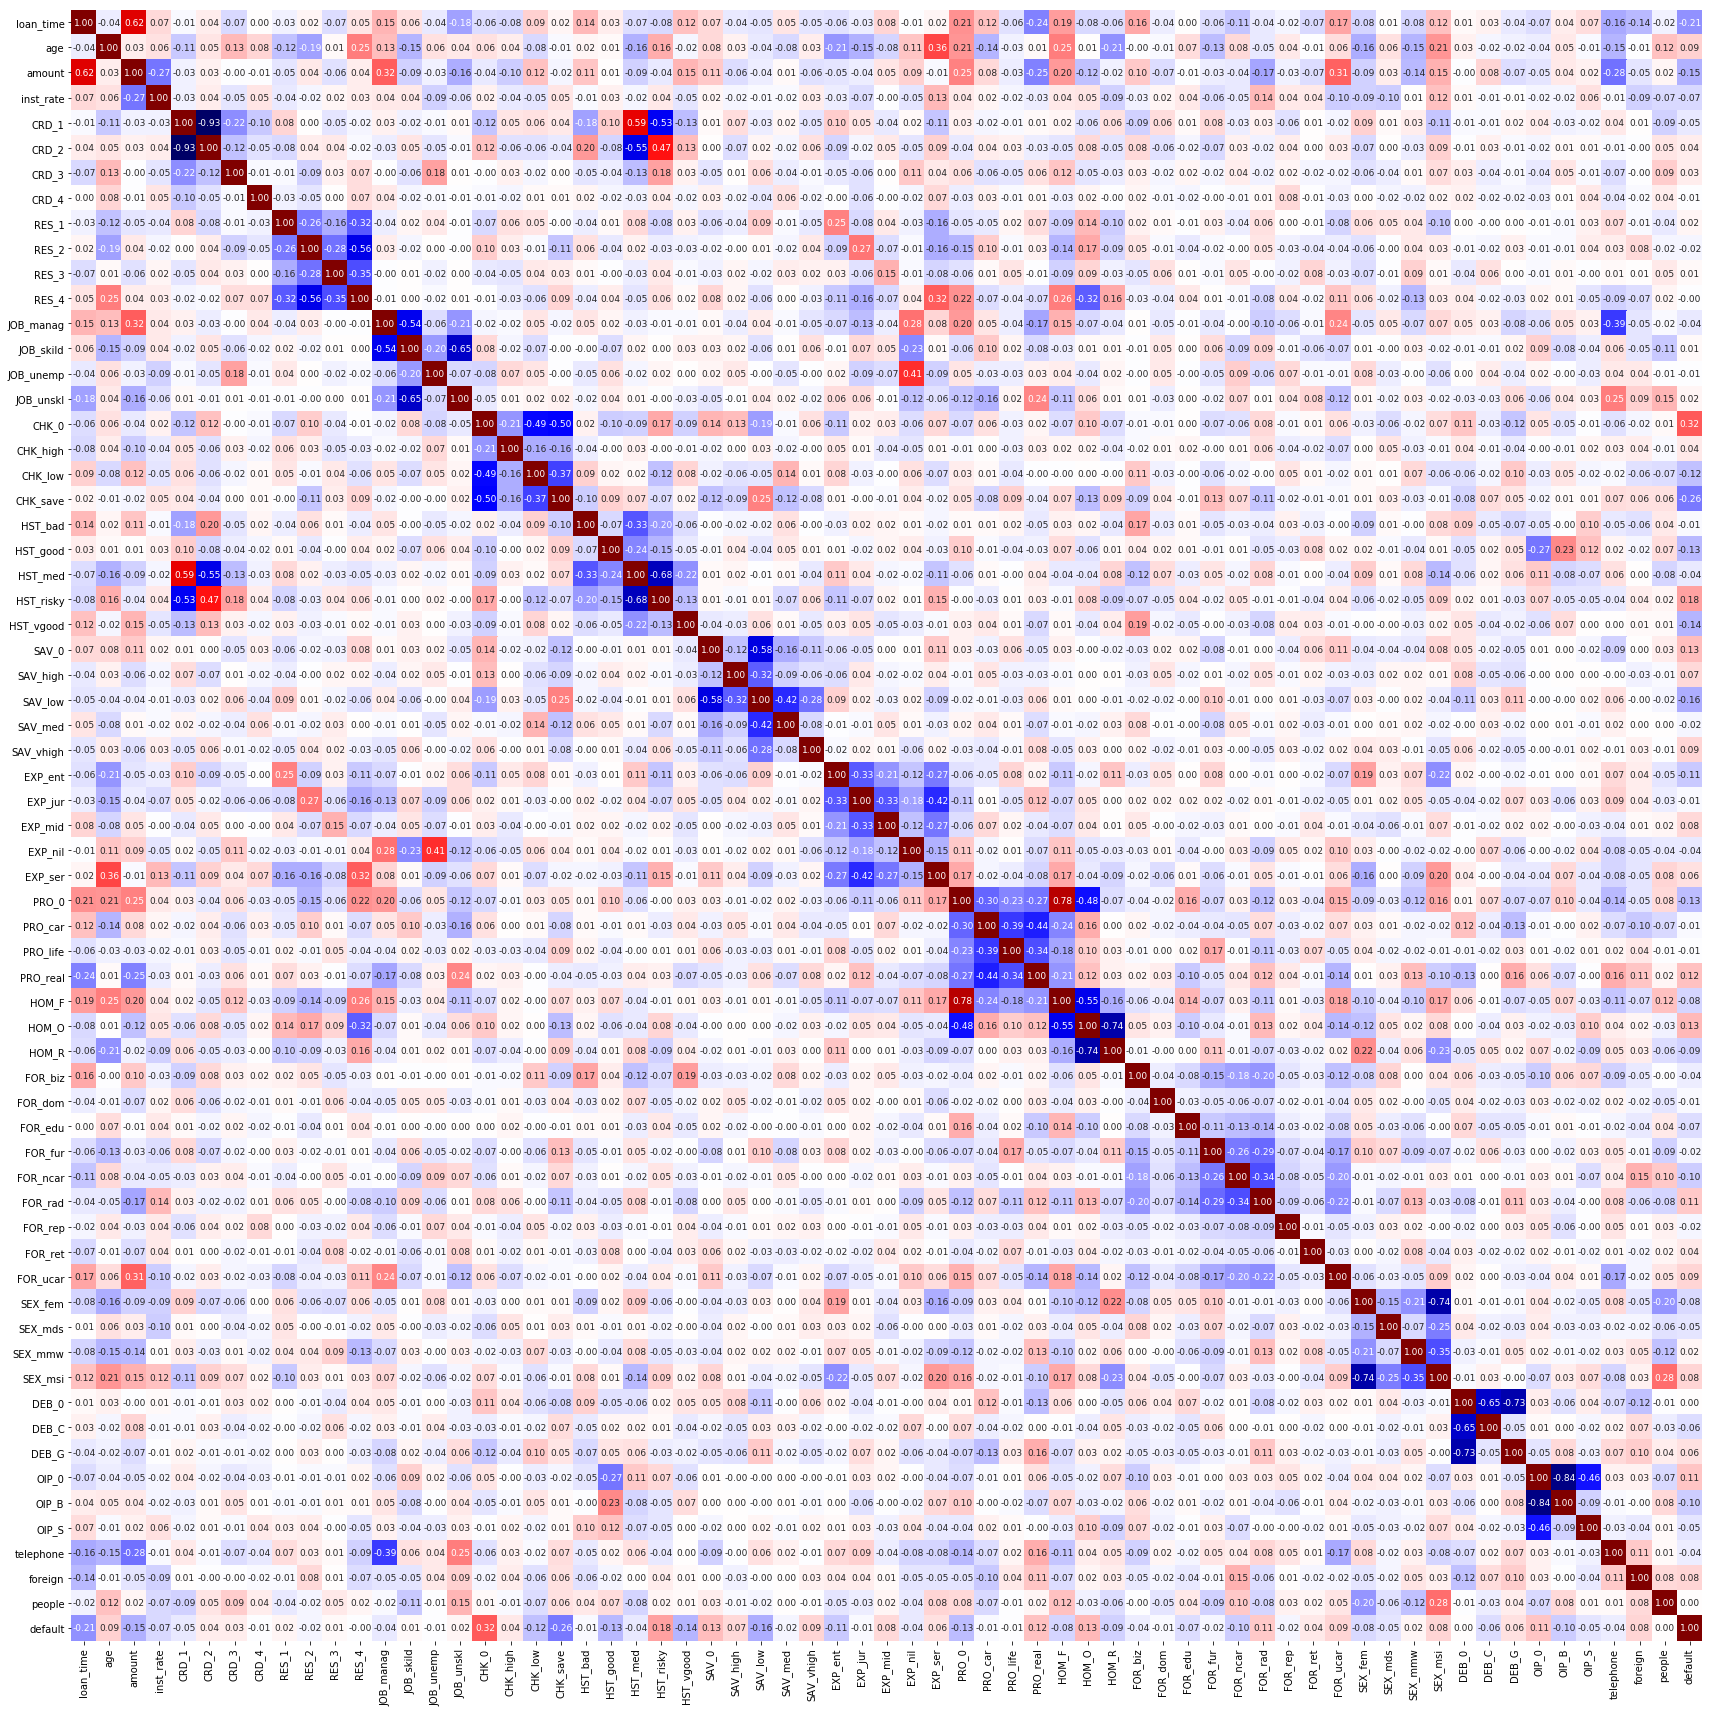

In [6]:
# Some old crap
dicts = [{4:4,1:1,2:2,3:3}, # ..................................................................................................................................n_credits
         {2:2,4:4,3:3,1:1}, # ..................................................................................................................................residence
         {'man/self-em/HQ/off':'manag','unemp / unskill (non-res)':'unemp','skilled / official':'skild','unskilled (resident)':'unskl'}, # .....................job
         {'< 0':'save','0 to 200':'low','> 201':'high','none':0}, # ............................................................................................checking
         {'fully repaid':'vgood','fully repaid here':'good','repaid':'med','delayed':'bad','critical':'risky'}, # ..............................................history
         {'<100':'low','101 to 500':'med','unk_nil':0,'501 to 1000':'high','>1000':'vhigh'}, # .................................................................savings
         {'less than 1':'ent','unemployed':'nil','1 to less than 4':'jur','more than 7':'ser','4 to less than 7':'mid'}, # .....................................job_status
         {'UNK/None':0,'Car/Other':'car','BSSA/Life':'life','real estate':'real'}, # ...........................................................................property
         {'own':'O','free':'F','rent':'R'}, # ..................................................................................................................housing
         {'edu':'edu','car_new':'ncar','repairs':'rep','business':'biz','dom_app':'dom','fur_equ':'fur','rad_tel':'rad','car_used':'ucar','retain':'ret'}, # ...for
         {'male_ds':'mds','female':'fem','male_mw':'mmw','male_single':'msi'}, # ...............................................................................sex
         {'coapplicant':'C','none':0,'guarantor':'G'}, # .......................................................................................................debtor
         {'none':0,'bank':'B','stores':'S'}] # .................................................................................................................OIP

hot_encode_these = ['n_credits','residence','job','checking','history','savings',
                    'job_status','property','housing','for','sex','debtor','OIP']

CA_he = pd.DataFrame(columns=hot_encode_these)

for n,col in enumerate(hot_encode_these):
    CA_he[col]= raw[col].map(dicts[n])

prefs = ['CRD','RES','JOB','CHK','HST','SAV',
         'EXP','PRO','HOM','FOR','SEX','DEB','OIP']

CA_he = pd.get_dummies(CA_he,columns=hot_encode_these[0:15], prefix=prefs, 
                       drop_first=False)

NU_he = raw[['loan_time','age','amount','inst_rate']]

BI_he = raw[['telephone','foreign','people']]

ohe_data = pd.concat([NU_he, CA_he, BI_he], axis=1)

#print feature_names


data = pd.concat([ohe_data, pd.DataFrame(data=y,columns=['default'])], axis=1)
n = 30
fig = plt.figure(figsize=[n,n])
corr_plot = sns.heatmap(data.corr(), annot=True, fmt=".2f", square=True, 
                        cmap='seismic', cbar=False, annot_kws={"size": 9},
                        vmin=-1, vmax=1)
plt.show()
fig.savefig('foo.png')


#data.drop(['CRD_1','CRD_2','CRD_3','CRD_4',
#           'PPL_1','PPL_2',
#           'INR_1','INR_2','INR_3','INR_4',
#           'RES_1','RES_2','RES_3','RES_4',
#           'JOB_manag','JOB_skild','JOB_unemp','JOB_unskl',
#           'DEB_0','DEB_C','DEB_G',
#           'SEX_mds','SEX_mmw','SEX_msi',
#           'HST_vgood','HST_good','HST_med','HST_bad',
#           'SAV_high','SAV_med','SAV_vhigh','SAV_0',
#           'EXP_mid','EXP_ser',
#           'PRO_0','PRO_car','PRO_life',
#           'foreign','CHK_0','HOM_O','FOR_rad','telephone'], axis = 1, inplace = True)

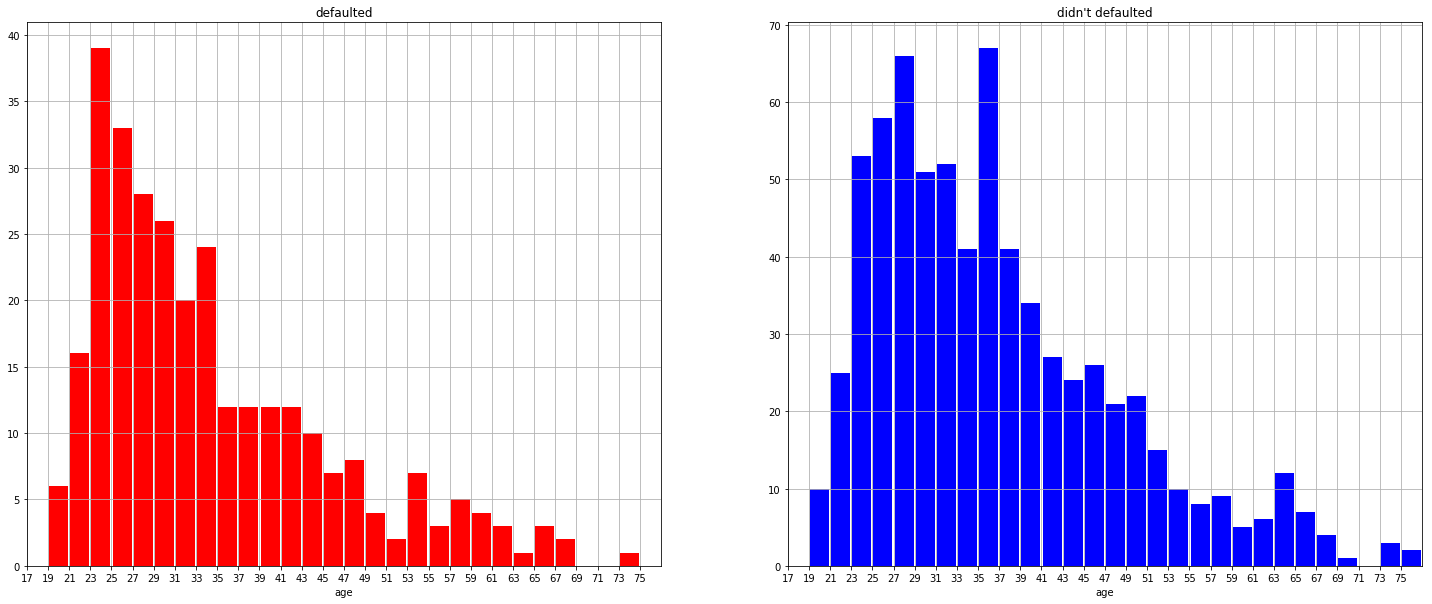

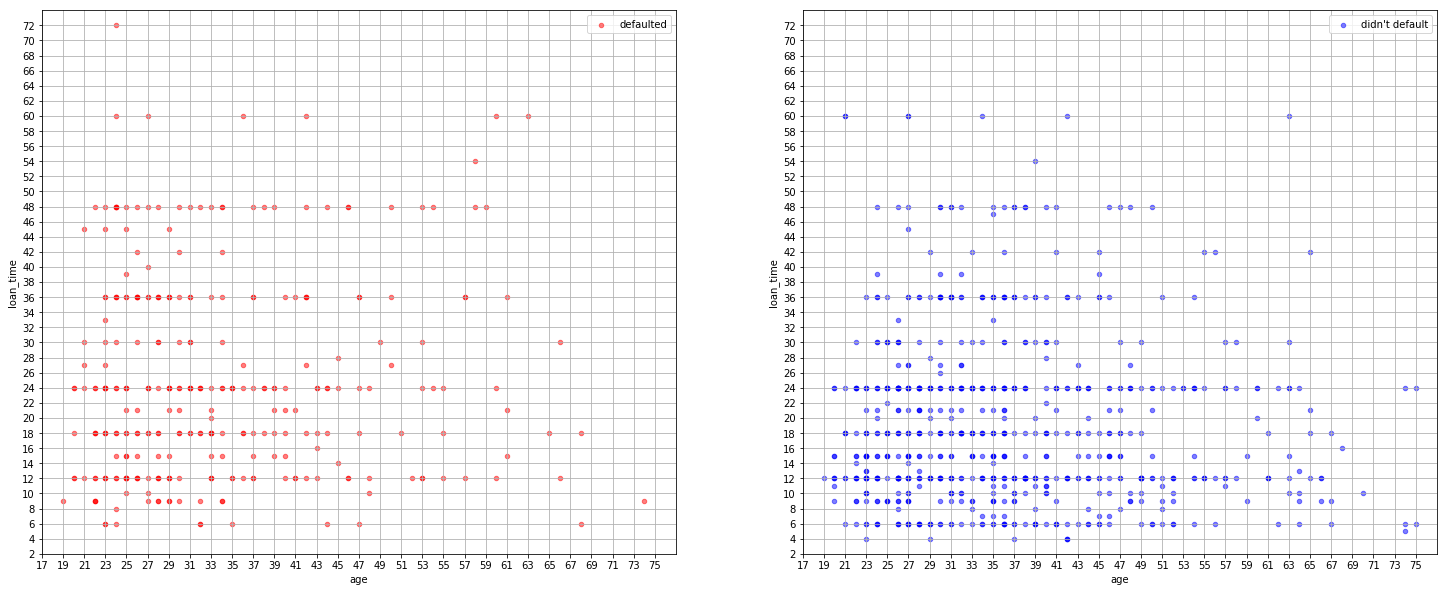

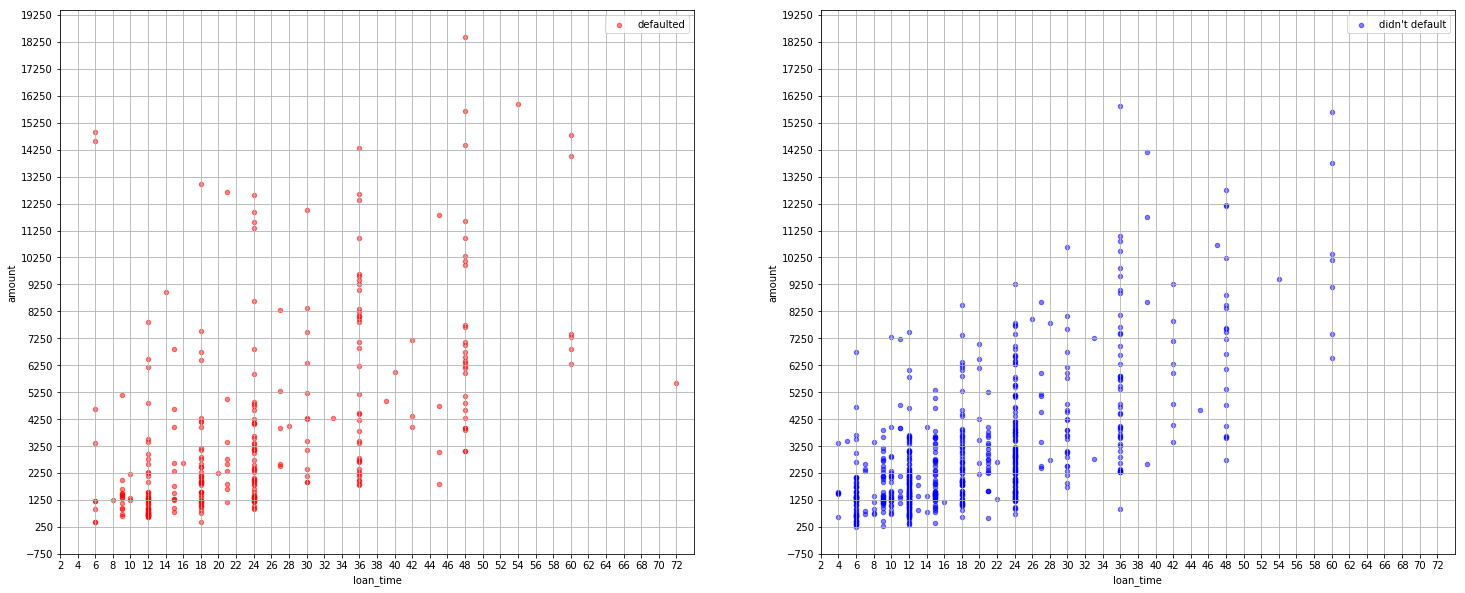

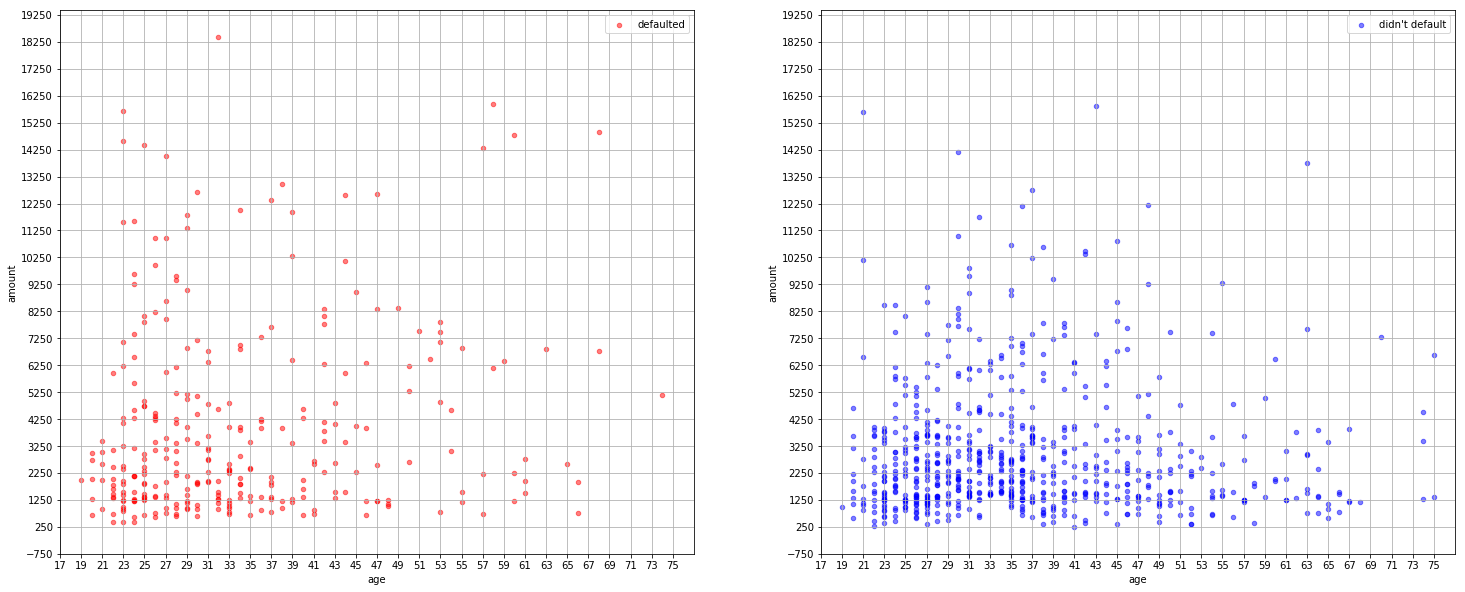

In [199]:
# Old graph stuff
def scatter_plot(data,y_name,x_name,ydiv,xdiv,size,a):
    ylims = [min(data.loc[:,y_name].values)-ydiv, 
             max(data.loc[:,y_name].values)+ydiv]
    xlims = [min(data.loc[:,x_name].values)-xdiv, 
             max(data.loc[:,x_name].values)+xdiv]
    fig = plt.figure(figsize=[25,10])
    
    ax1 = fig.add_subplot(121); plt.xlabel(x_name); plt.ylabel(y_name)
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1])); 
    plt.yticks(np.arange(ylims[0],ylims[1],ydiv)); plt.ylim((ylims[0],ylims[1])); 
    y0 = data[data['default']==1].loc[:,y_name].values
    x = data[data['default']==1].loc[:,x_name].values
    ax1.scatter(x,y0,c='r',marker='o',s=size,alpha=a,label='defaulted')
    ax1.grid(True); ax1.legend(loc='best')

    ax2 = fig.add_subplot(122); plt.xlabel(x_name); plt.ylabel(y_name)
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1])); 
    plt.yticks(np.arange(ylims[0],ylims[1],ydiv)); plt.ylim((ylims[0],ylims[1]));
    y0 = data[data['default']==2].loc[:,y_name].values
    x = data[data['default']==2].loc[:,x_name].values
    ax2.scatter(x,y0,c='b',marker='o',s=size,alpha=a,label="didn't default")
    ax2.grid(True); ax2.legend(loc='best')
    return plt.show()

def hist_plot(data,name,xdiv,ydiv,ymax):
    
    xlims = [min(data.loc[:,name].values)-xdiv, max(data.loc[:,name].values)+xdiv]
    bins = range(xlims[0],xlims[1]+xdiv,xdiv)
    fig = plt.figure(figsize=[25,10])
    
    ax1 = fig.add_subplot(121); plt.xlabel(name); plt.title('defaulted')
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1]));  
    pop = data[data['default']==1].loc[:,name].values
    ax1.hist(pop, bins, color='r', rwidth=0.9);ax1.grid(True)
    
    ax2 = fig.add_subplot(122); plt.xlabel(name); plt.title("didn't defaulted")
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1]));
    pop = data[data['default']==2].loc[:,name].values
    ax2.hist(pop, bins, color='b', rwidth=0.9);ax2.grid(True)
    return plt.show()

hist_plot(raw,'age',2)

scatter_plot(raw,'loan_time','age',2,2,20,0.5)
scatter_plot(raw,'amount','loan_time',1000,2,20,0.5)
scatter_plot(raw,'amount','age',1000,2,20,0.5)

64


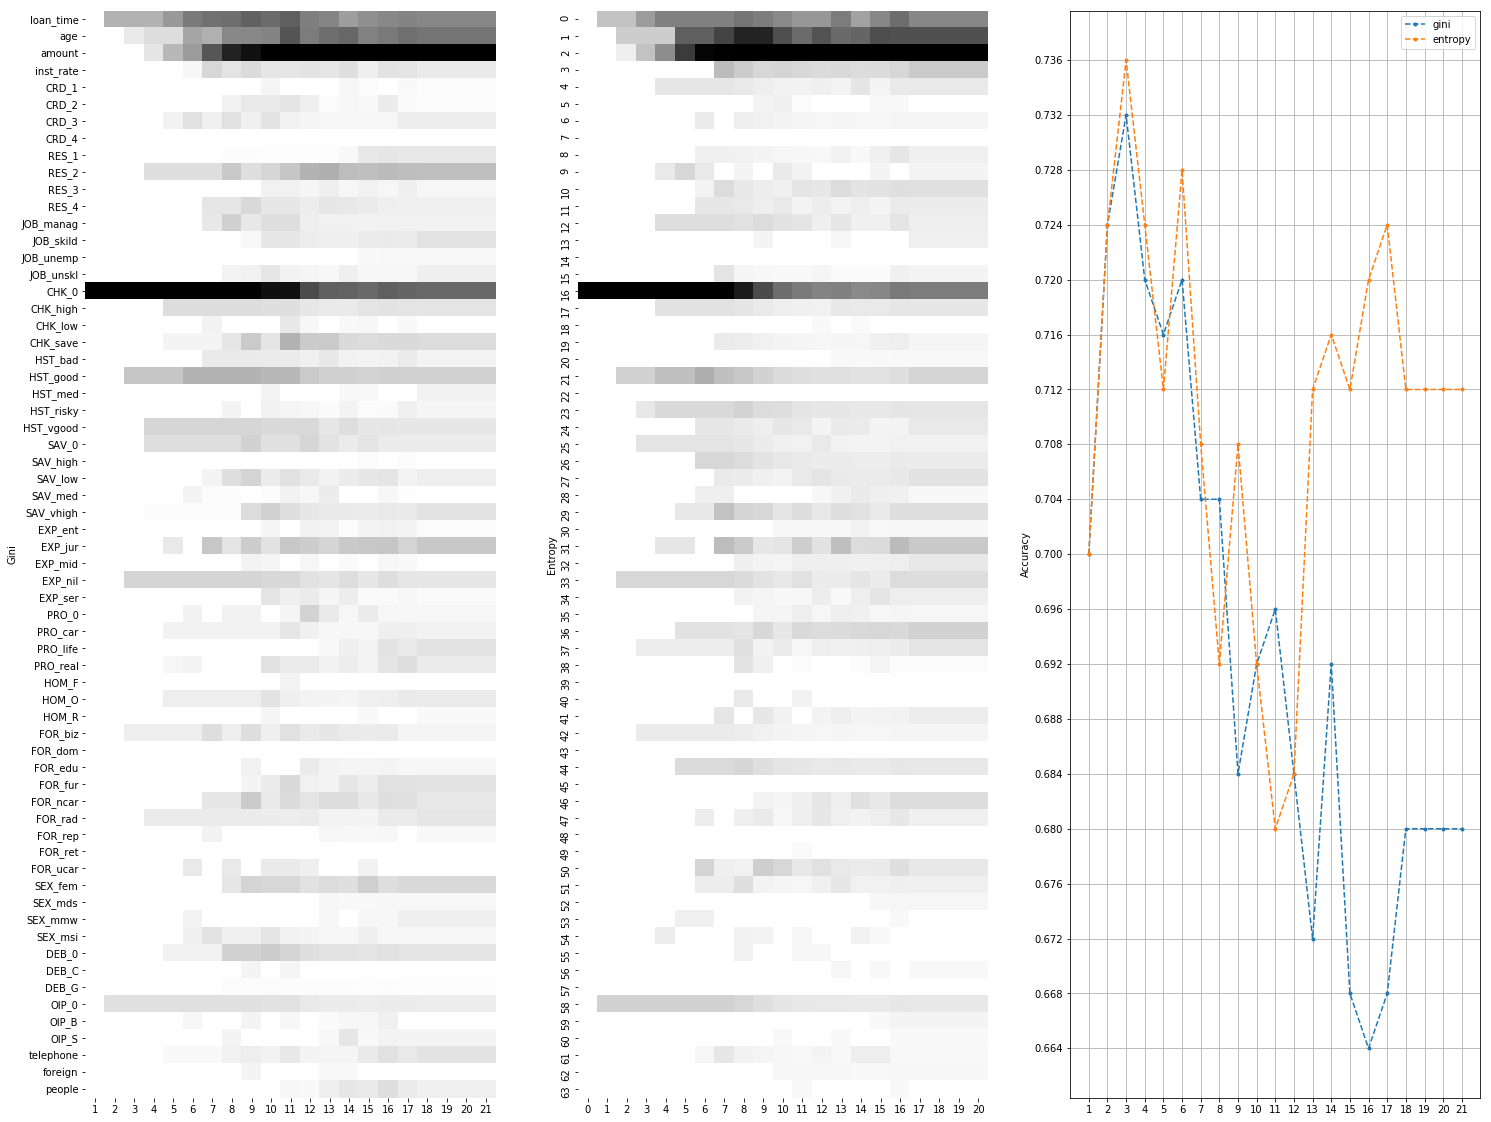

RFC (750L, 43L) 0.7 [ 0  1  2  3  4  5  8  9 10 11 12 13 15 16 18 19 20 21 22 23 25 27 30 31 32
 34 35 36 37 38 40 41 45 46 47 51 54 55 58 59 60 61 63]
GBC (750L, 42L) 0.784 [ 0  1  2  3  4  8  9 12 16 17 18 19 20 21 22 23 24 25 27 29 30 32 33 35 36
 38 40 41 42 44 46 47 50 51 52 55 56 57 58 59 60 62]
ADA (750L, 26L) 0.744 [ 0  1  2  3  4  8  9 16 17 19 21 23 25 30 32 38 40 46 47 48 50 52 54 57 58
 62]
LRC (750L, 64L) 0.736 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
VEC (750L, 64L) 0.736 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
DTC (750L, 5L) 0.648 [ 0  1  2  3 16]


In [158]:
# RFECV Attempt
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

X = ohe_data.values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=2017)
feature_names = ohe_data.columns.values
print len(feature_names)
#######################################
# Stand Alone DT max_depth assessment
#######################################
fig = plt.figure(figsize=[25,20]); max_depth = 22
ax1 = fig.add_subplot(133);plt.ylabel("Accuracy"); 
plt.yticks(np.arange(0.66,0.80,0.004)); 
plt.xticks(np.arange(1,max_depth,1))
ax2 = fig.add_subplot(131); ax3 = fig.add_subplot(132)
for criteria in ('gini','entropy'):
    test_accuracy = []; imps = []
    for depth in range(1,max_depth):
        tree = DecisionTreeClassifier(max_depth=depth, criterion=criteria, 
                                      random_state=2017).fit(X_train,y_train); 
        test_accuracy.append(tree.score(X_test, y_test))
        fea = tree.feature_importances_.tolist(); 
        max0 = max(fea); 
        min0 = min(fea); 
        fea = list(map((lambda x: (x-min0)/(max0-min0)),fea)); imps.append(fea)
    fea_imp = pd.DataFrame(data=imps, columns=feature_names, 
                           index=range(1,max_depth))
    c = 'binary'
    if criteria=='gini':
        sns.heatmap(fea_imp.T, annot=False, fmt=".2f", square=False, cmap=c,
                    ax=ax2, cbar=False,annot_kws={"size": 8})
    else:
        sns.heatmap(fea_imp.T.values, annot=False, fmt=".2f", square=False, 
                    cmap=c,ax=ax3, cbar=False,annot_kws={"size": 8})
    ax1.plot(range(1,max_depth),test_accuracy,'--.',label=criteria)
ax1.grid(True); 
ax1.legend(loc='best'); 
ax2.set_ylabel('Gini'); 
ax3.set_ylabel('Entropy'); 
plt.show()

RFC = RandomForestClassifier(max_features='sqrt', bootstrap=False,
                             random_state=2017)
GBC = GradientBoostingClassifier(max_features=None,random_state=2017)
ADA = AdaBoostClassifier(random_state=2017)
BGC = BaggingClassifier(random_state=2017)
LRC = LogisticRegression(solver='liblinear',random_state=2017, max_iter=1000)
VEC = LinearSVC(dual=False,random_state=2017)
DTC = DecisionTreeClassifier(random_state=2017)
models = [RFC,GBC,ADA,BGC,LRC,VEC,DTC]
model_names = ['RFC','GBC','ADA','BGC','LRC','VEC','DTC']

skf = StratifiedKFold(n_splits=8, random_state=2017)

for count, model in enumerate(models):
    if count !=3:
        f = RFECV(model, n_jobs=8, cv=skf, 
                  scoring='roc_auc').fit(X_train, y_train)
        t = f.transform(X_train)
        print model_names[count],
        print t.shape,
        print f.score(X_test,y_test),
        print f.get_support(indices=True)